In [12]:
import os
import pandas as pd
from datetime import datetime
import dateutil
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
#from osgeo import gdal
import rasterio
#import folium
import pickle
#import contextily as cx
from sklearn.preprocessing import normalize
import re
import itertools
#import statsmodels 
#import statsmodels.api as sm

# Exploratory Data Analysis
- Number of downloaded timestamps
- Distribution of timestamps
- Missing data (missing bands in folders)
- Variable description (Poornima)
    - Histogram
- Temporal variation of bands (Grabska, Bastos)
    - Between drought/non drought
- Correlation between variables (Poornima)
- Map out NDVI (Park2016, Prodhan, Sturm)
    - Can we visually see anomaly when drought?

## Sentinel-2

In [14]:
SEN_PATH = '/dccstor/cimf/drought_impact/downloads/SENTINEL 2'
ERA_PATH = '/dccstor/cimf/drought_impact/downloads/ERA5'
data_path = SEN_PATH

### Number of downloaded timestamps
Clean data first

In [5]:
print('Number of timestamps:', len([folder for folder in os.listdir(data_path) if '46.907_7.137_47.407_7.637' in folder]))

Number of timestamps: 386


### Distribution of timestamps

In [6]:
# Extract timestamps and location from folder names
folder_list = [x for x in os.listdir(data_path) if '46.907_7.137_47.407_7.637' in x]
df = pd.DataFrame(folder_list, columns=['folder']) 
df = df[df.folder.str.match('2')] # keep only folders of actual data
df['timestamp'] = df.folder.apply(lambda x: datetime.strptime(x.split('/')[-1].split('Z')[0], '%Y-%m-%dT%H:%M:%S'))
df = df.sort_values('timestamp')
df['location'] = df.folder.apply(lambda x: x.split('Z_')[1])

In [7]:
# Some explorative stats

print('Number of sentinel 2 timestamps per year:', df.groupby(pd.Grouper(key='timestamp', axis=0, freq='Y')).count().folder, '\n')
# Could aslo add swath and group by swath too

df["timedelta"] = df.timestamp.diff()
df["timedelta"] = df["timedelta"].apply(lambda x: x.days)
print('Average time step for sentinel 2 images:', df[df["timedelta"]>0].timedelta.mean(), 'days')

"""
#ERA5
print('Number of ERA5 timestamps per year:', df.groupby(pd.Grouper(key='timestamp', axis=0, freq='Y')).count().folder, '\n')
# Could aslo add swath and group by swath too

df["timedelta"] = df.timestamp.diff()
df["timedelta"] = df["timedelta"].apply(lambda x: x.days)
print('Average time step for ERA5 images:', df[df["timedelta"]>0].timedelta.mean(), 'days')
"""

Number of sentinel 2 timestamps per year: timestamp
2015-12-31    11
2016-12-31    34
2017-12-31    49
2018-12-31    73
2019-12-31    73
2020-12-31    73
2021-12-31    73
Freq: A-DEC, Name: folder, dtype: int64 

Average time step for sentinel 2 images: 6.064935064935065 days


'\n#ERA5\nprint(\'Number of ERA5 timestamps per year:\', df.groupby(pd.Grouper(key=\'timestamp\', axis=0, freq=\'Y\')).count().folder, \'\n\')\n# Could aslo add swath and group by swath too\n\ndf["timedelta"] = df.timestamp.diff()\ndf["timedelta"] = df["timedelta"].apply(lambda x: x.days)\nprint(\'Average time step for ERA5 images:\', df[df["timedelta"]>0].timedelta.mean(), \'days\')\n'

In [8]:
# Consider only "complete" folders for now

normal_folders = []
cp_folders = [] # folders that mainly have cloud probability
for folder in os.listdir(data_path):
    filelist = [file for file in os.listdir(data_path+'/'+folder) if file.endswith('.tiff')]
    if len(filelist)<=6: #cp, msi, ndmi, ndwi, ndvire. Most cp folders have 5 tiffs, but b03 downloaded with that bunch too so there is a folder with 6 tiffs
        cp_folders += [folder]
    if len(filelist)>6:
        normal_folders += [folder]
        
df = df[df.folder.isin(normal_folders)]

# Some explorative stats
print('Number of timestamps:', len(df))

print('Number of sentinel 2 timestamps per year:', df.groupby(pd.Grouper(key='timestamp', axis=0, freq='Y')).count().folder, '\n')
# Could aslo add swath and group by swath too

df["timedelta"] = df.timestamp.diff()
df["timedelta"] = df["timedelta"].apply(lambda x: x.days)
print('Average time step for sentinel 2 images:', df[df["timedelta"]>0].timedelta.mean(), 'days')


"""
# Some explorative stats
print('Number of timestamps:', len(df))

print('Number of ERA5 timestamps per year:', df.groupby(pd.Grouper(key='timestamp', axis=0, freq='Y')).count().folder, '\n')
# Could aslo add swath and group by swath too

df["timedelta"] = df.timestamp.diff()
df["timedelta"] = df["timedelta"].apply(lambda x: x.days)
print('Average time step for ERA5 images:', df[df["timedelta"]>0].timedelta.mean(), 'days')
"""

Number of timestamps: 386
Number of sentinel 2 timestamps per year: timestamp
2015-12-31    11
2016-12-31    34
2017-12-31    49
2018-12-31    73
2019-12-31    73
2020-12-31    73
2021-12-31    73
Freq: A-DEC, Name: folder, dtype: int64 

Average time step for sentinel 2 images: 6.064935064935065 days


'\n# Some explorative stats\nprint(\'Number of timestamps:\', len(df))\n\nprint(\'Number of ERA5 timestamps per year:\', df.groupby(pd.Grouper(key=\'timestamp\', axis=0, freq=\'Y\')).count().folder, \'\n\')\n# Could aslo add swath and group by swath too\n\ndf["timedelta"] = df.timestamp.diff()\ndf["timedelta"] = df["timedelta"].apply(lambda x: x.days)\nprint(\'Average time step for ERA5 images:\', df[df["timedelta"]>0].timedelta.mean(), \'days\')\n'

NameError: name 'palette' is not defined

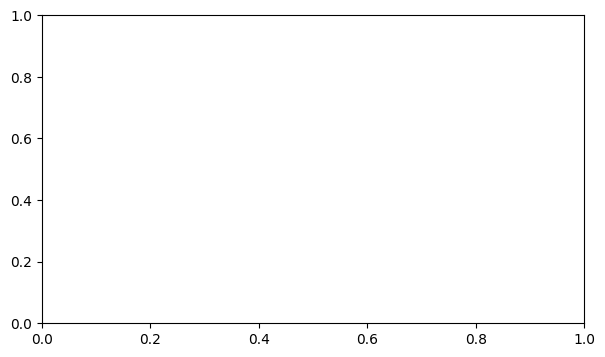

In [9]:
times_per_yr = df.groupby(pd.Grouper(key='timestamp', axis=0, freq='Y')).count().folder.reset_index()
times_per_yr['timestamp'] = times_per_yr['timestamp'].apply(lambda x: x.year)
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.grid(False)
#palette = sns.color_palette("tab10")
sns.barplot(ax=ax, data=times_per_yr, x="timestamp", y="folder", color=palette[0], edgecolor='black')
plt.title('Number of timestamps per year')
plt.ylabel('# timestamps')
plt.xlabel('Year')

In [8]:
df_2017 = df[df.timestamp<'2017-06-29']
print('Average time step for sentinel 2 images (before 29th June 2017):', df_2017[df_2017["timedelta"]>0].timedelta.mean(), 'days')

df_2018 = df[df.timestamp>='2017-06-29']
print('Average time step for sentinel 2 images (after 29th June 2017):', df_2018[df_2018["timedelta"]>0].timedelta.mean(), 'days')

Average time step for sentinel 2 images (before 29th June 2017): 11.724137931034482 days
Average time step for sentinel 2 images (after 29th June 2017): 5.061162079510703 days


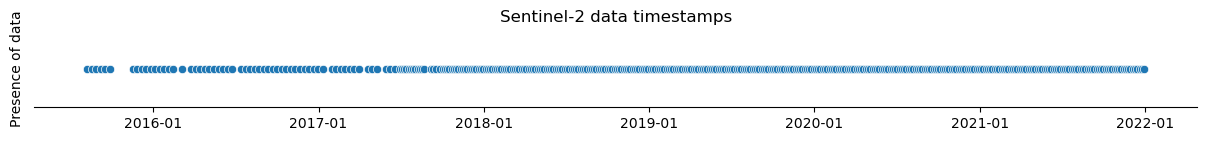

In [9]:
# Plot of timestamps: all locations combined, all years

datelist = df["timestamp"].astype(str).to_list()
timestamplist = [dateutil.parser.parse(x) for x in datelist]
length = len(datelist)

df_byyear = pd.DataFrame()
df_byyear["timestamplist"] = timestamplist
df_byyear["val"] = [0] * len(df_byyear)

fig, ax = plt.subplots(1, 1, figsize=(15, 1))
plt.title('Sentinel-2 data timestamps')
sns.scatterplot(ax=ax, x='timestamplist', y='val', data=df_byyear)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel("")
plt.ylabel("Presence of data")
plt.yticks([])  # Command for hiding y-axis
# Remove figure box
#fig.patch.set_visible(False)
#ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

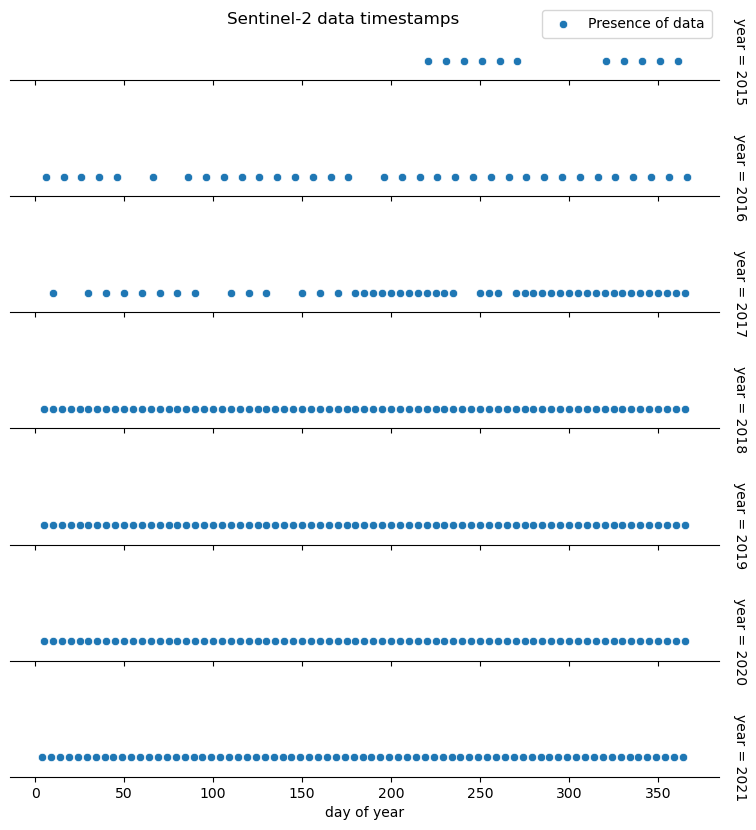

In [10]:
# Plot of timestamps: all locations combined, compare years

datelist = df["timestamp"].astype(str).to_list()
timestamplist = [dateutil.parser.parse(x) for x in datelist]
length = len(datelist)

# Compare different years
df_byyear = pd.DataFrame()
df_byyear["timestamplist"] = timestamplist
df_byyear["val"] = [0] * len(df_byyear)
df_byyear['year'] = df_byyear.timestamplist.apply(lambda x: x.year)
df_byyear['day'] = df_byyear.timestamplist.apply(lambda x: x.dayofyear)
df_byyear['month'] = df_byyear.timestamplist.apply(lambda x: x.month)
df_byyear['month'] = df_byyear.timestamplist.apply(lambda x: x.month_name())
df_byyear['week'] = df_byyear.timestamplist.apply(lambda x: x.week)


g = sns.FacetGrid(df_byyear, row="year", margin_titles=True, height=1.2, aspect=7)
g.fig.suptitle('Sentinel-2 data timestamps')
g.map(sns.scatterplot, "day", "val")
plt.xlabel("day of year")
#g.set_ylabels("Presence of data")
g.set_ylabels("")
g.set(yticks=[])  # Command for hiding y-axis ticks
plt.subplots_adjust(hspace=2) #adjust pace between rows
sns.despine(left=True)
plt.legend(['Presence of data'], bbox_to_anchor=(1, 20), borderpad=.5)
#g.fig.text(0,0,'test')

In [ ]:
# check specific missing dates
#df_byyear[(df_byyear.day>240) & (df_byyear.day<280)]

In [ ]:
# Plot of timestamps: different locations, all years

fig, ax = plt.subplots(1, 1, figsize=(15, 1))
plt.title('Sentinel-2 data timestamps per location')
sns.scatterplot(ax=ax, x='timestamp', y='location', data=df, hue='location')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel("")
plt.ylabel("Presence of data")
plt.yticks([])  # Command for hiding y-axis
# Remove figure box
#fig.patch.set_visible(False)
#ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# Plot of timestamps: different locations, compare years

df_byyear = df.copy()
df_byyear['year'] = df_byyear.timestamp.apply(lambda x: x.year)
df_byyear['month'] = df_byyear.timestamp.apply(lambda x: x.month)
df_byyear['month'] = df_byyear.timestamp.apply(lambda x: x.month_name())

g = sns.FacetGrid(df_byyear, row="year", margin_titles=True, height=1.5, aspect=7, hue='location')
g.fig.suptitle('Sentinel-2 data timestamps')
g.map(sns.scatterplot, "month", "location")
plt.xlabel("")
g.set_ylabels("Presence of data")
g.set(yticks=[])  # Command for hiding y-axis
plt.subplots_adjust(hspace=2) #adjust pace between rows
g.add_legend()

In [ ]:
# Could also compare different satellite swaths
# FIRST NEED TO ADD SWATH TO DF!!

# Compare different swaths
datelist = df["timestamp"].astype(str).to_list()
timestamplist = [dateutil.parser.parse(x) for x in datelist]
length = len(datelist)
geomlist = df["location"].to_list()
swathlist = df["swath"].to_list()

# Compare different years
df_byyear = pd.DataFrame()
df_byyear["timestamplist"] = timestamplist
df_byyear["geom"] = geomlist
df_byyear["swath"] = swathlist
df_byyear['year'] = df_byyear.timestamplist.apply(lambda x: x.year)
df_byyear['day'] = df_byyear.timestamplist.apply(lambda x: x.dayofyear)
df_byyear['month'] = df_byyear.timestamp.apply(lambda x: x.month)
df_byyear['month'] = df_byyear.timestamp.apply(lambda x: x.month_name())
df_byyear['week'] = df_byyear.timestamplist.apply(lambda x: x.week)


g = sns.FacetGrid(df_byyear, row="year", margin_titles=True, height=1.3, aspect=7 ,hue='swath')
g.fig.suptitle('Sentinel-2 timestms per swath')
g.map(sns.scatterplot, "month", "swath")
plt.xlabel("")
g.set_ylabels("Presence of data")
g.set(yticks=[])  # Command for hiding y-axis
plt.subplots_adjust(hspace=2) #adjust pace between rows
g.add_legend()

### Missing data

In [10]:
# Missing timesteps
#df_missdate = df[(df.timedelta>5) & (df.timedelta!=10)]
df_miss2017 = df[df.timestamp<'2017-06-29']
df_miss2018 = df[df.timestamp>'2017-06-29']
miss2017 = df_miss2017[df_miss2017.timedelta>10]
miss2018 = df_miss2018[df_miss2018.timedelta>5]
print('Number of msing dates:', miss2017.timedelta.sum()/10-len(miss2017) + miss2018.timedelta.sum()/5-len(miss2018)) 

Number of msing dates: 13.0


In [11]:
miss2017

folder  timestamp  \
1    2015-11-17T00:00:00Z_46.907_7.137_47.407_7.637 2015-11-17   
290  2016-03-06T00:00:00Z_46.907_7.137_47.407_7.637 2016-03-06   
93   2016-03-26T00:00:00Z_46.907_7.137_47.407_7.637 2016-03-26   
131  2016-07-14T00:00:00Z_46.907_7.137_47.407_7.637 2016-07-14   
81   2017-01-30T00:00:00Z_46.907_7.137_47.407_7.637 2017-01-30   
125  2017-04-20T00:00:00Z_46.907_7.137_47.407_7.637 2017-04-20   
312  2017-05-30T00:00:00Z_46.907_7.137_47.407_7.637 2017-05-30   

                      location  timedelta  
1    46.907_7.137_47.407_7.637       50.0  
290  46.907_7.137_47.407_7.637       20.0  
93   46.907_7.137_47.407_7.637       20.0  
131  46.907_7.137_47.407_7.637       20.0  
81   46.907_7.137_47.407_7.637       20.0  
125  46.907_7.137_47.407_7.637       20.0  
312  46.907_7.137_47.407_7.637       20.0

In [12]:
expected_bands = ["B04", "B03", "B02", "B08", "[NDVI]", "SCL", "B8a", "B12", "B11", "B05", "B06", "B07", "CP", "NDWI", "NDMI", "MSI", "NDVIre"]

df['bands'] = [0]*len(df)

for idx, row in df.iterrows():
    folder = row.folder
    bands = []
    for file in os.listdir(data_path + '/' + folder):
        if file.endswith('.tiff'):
            file_band = [band for band in expected_bands if band in file]
            if file_band: # if matches were found
                bands.append(file_band[-1]) # Since for NDVIre it first will find NDVI
    df['bands'][idx] = bands

/tmp/ipykernel_1469659/866224476.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bands'][idx] = bands


In [13]:
df['nbr_bands'] = df.bands.apply(lambda x: len(x))
print('Avg number of bands:', df.nbr_bands.mean(), ' Max nbr:', df.nbr_bands.max(), ', Min nbr:', df.nbr_bands.min())
print('\n')
print('Dates and locations where bands missing:\n', df[df.nbr_bands<len(expected_bands)].folder)

Avg number of bands: 17.0  Max nbr: 17 , Min nbr: 17


Dates and locations where bands missing:
 Series([], Name: folder, dtype: object)


In [14]:
df_exp = df.explode('bands')
print('Number of times band is present: \n', df_exp.groupby('bands').location.count())

Number of times band is present: 
 bands
B02       386
B03       386
B04       386
B05       386
B06       386
B07       386
B08       386
B11       386
B12       386
B8a       386
CP        386
MSI       386
NDMI      386
NDVIre    386
NDWI      386
SCL       386
[NDVI]    386
Name: location, dtype: int64


In [15]:
df['missing_bands'] = df.bands.apply(lambda x: list(set(expected_bands) - set(x)))
df.head()

folder  timestamp  \
178  2015-08-09T00:00:00Z_46.907_7.137_47.407_7.637 2015-08-09   
14   2015-08-19T00:00:00Z_46.907_7.137_47.407_7.637 2015-08-19   
63   2015-08-29T00:00:00Z_46.907_7.137_47.407_7.637 2015-08-29   
6    2015-09-08T00:00:00Z_46.907_7.137_47.407_7.637 2015-09-08   
452  2015-09-18T00:00:00Z_46.907_7.137_47.407_7.637 2015-09-18   

                      location  timedelta  \
178  46.907_7.137_47.407_7.637        NaN   
14   46.907_7.137_47.407_7.637       10.0   
63   46.907_7.137_47.407_7.637       10.0   
6    46.907_7.137_47.407_7.637       10.0   
452  46.907_7.137_47.407_7.637       10.0   

                                                 bands  nbr_bands  \
178  [SCL, B07, NDVIre, NDWI, CP, B03, B11, MSI, B0...         17   
14   [CP, NDVIre, [NDVI], B03, B11, NDWI, B04, B05,...         17   
63   [B08, B04, [NDVI], B8a, NDVIre, SCL, B07, NDWI...         17   
6    [NDVIre, NDWI, [NDVI], B08, MSI, B02, B04, B05...         17   
452  [B08, NDVIre, B11, B06, NDWI, B04, MSI, B12, B...         17   

    missing_bands  
178            []  
14             []  
63             []  
6              []  
452            []

(0.0, 400.0)

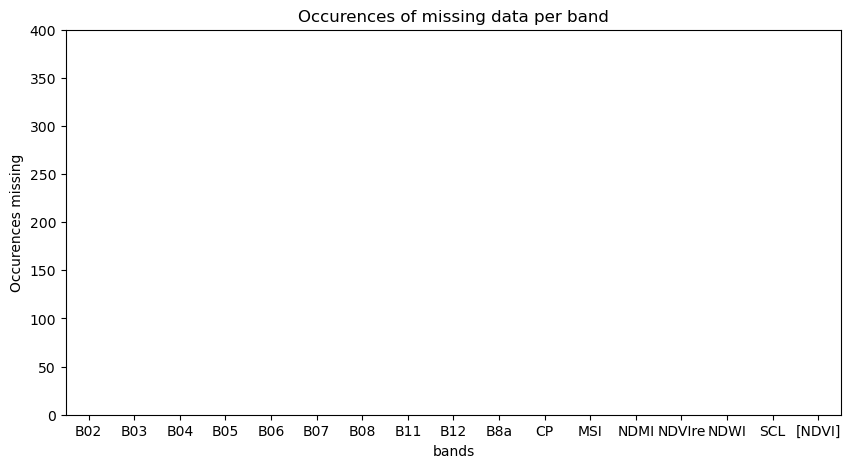

In [16]:
df["nbr_missing"] = df.missing_bands.apply(lambda x: len(x))
df_missingbands = df.explode('bands').groupby('bands').sum().reset_index()
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.grid(False)
sns.barplot(ax=ax, data=df_missingbands, x="bands", y="nbr_missing", color='tab:blue')
plt.title('Occurences of missing data per band')
plt.ylabel('Occurences missing')
plt.ylim([0, 400])

### Variable description

#### Plot rasters

In [ ]:
#bands = ["B04", "B03", "B02", "B08", "NDVI", "SCL", "B8a", "B12", "B11", "B05", "B06", "B07", "CP", "NDWI", "NDMI", "MSI", "NDVIre"]
bands = ["B03"]

for band in bands:
    band_data = np.array([])
    for folder in os.listdir(data_path):
        if '2' in folder:
            for file in os.listdir(data_path + '/' + folder):
                if (file.endswith('.tiff') & (band in file)):#(band + '_' in file) for NDVI
                    # should maybe mask for forest
                    #im = gdal.Open(data_path + '/' + folder + '/' + file)
                    #band_data = np.append(band_data, np.array(im.GetRasterBand(1).ReadAsArray()).flatten())
                    src = rasterio.open(data_path + '/' + folder + '/' + file)
                    arr = src.read(1)
                    # mask out nan values
                    arr[arr==-9999] = np.nan
                    masked_array = np.ma.array(arr, mask=np.isnan(arr))
                    plt.imshow(masked_array, aspect='auto', origin='lower')
                    plt.title(f'{file}')
                    plt.show()

### Forest mask

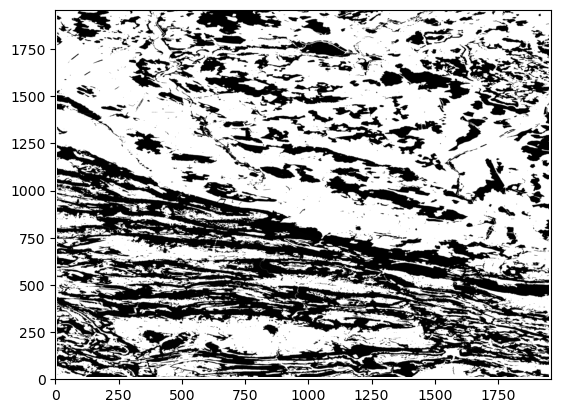

In [4]:
forest_mask =  '/dccstor/cimf/drought_impact/downloads/forest_mask/46.907_7.137_47.407_7.637/Drought-Continuous forest mask-11_03_2022T00_00_00.tiff'
with rasterio.open(forest_mask) as src:
    for_arr = src.read(1) # should be same resolution and extent as Sen 2 data ideally
for_arr[for_arr==-9999] = np.nan
#masked_array = np.ma.array(for_arr, mask=np.isnan(for_arr))
plt.imshow(for_arr, aspect='auto', origin='lower', cmap='binary')
plt.show()

In [ ]:
# Histogram of forest pixel coverage
fig, ax = plt.subplots(1,1, figsize=(5, 5))
plt.title("Historam of forest mask pixel values", fontsize=12, y=1)
sns.histplot(ax=ax, data=for_arr.flatten())
plt.show()

#### Binary forest mask

In [5]:
forest_binary = for_arr.copy()
forest_binary[np.isnan(forest_binary)]=0
forest_binary[forest_binary!=0]=1
forest_binary = (forest_binary==1)
forest_binary

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
# Some stats on forest pixels
print(f'Percentage of forest pixels in area: {(forest_binary.sum()*100/len(forest_binary.flatten())):.3f} %')

#### Binary forest mask (only if pixel >0.5)

In [6]:
# Make binary mask keeping only pixels that are >50% forest
forest_binary50 = for_arr.copy()
forest_binary50[np.isnan(forest_binary50)]=0
forest_binary50[forest_binary50<0.5]=0
forest_binary50[forest_binary50!=0]=1
forest_binary50 = (forest_binary50==1)
forest_binary50

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
# Some stats on forest pixels
print(f'Percentage of forest pixels in area: {(forest_binary50.sum()*100/len(forest_binary50.flatten())):.3f} %')

In [ ]:
# Randomly generate index of n forest pixels
for_pixs = np.random.randint(0, 1000, size=(1000))

"""
# Save for future use
with open('for_pixs.pkl', 'wb') as f:
    pickle.dump(for_pixs, f)
    
with open('for_pixs.pkl', 'rb') as f:
    for_pixs = pickle.load(f)
"""

In [16]:
# From SAC notebook

with open('for_pixs.pkl', 'rb') as f:
    for_pixs = pickle.load(f)

with open('row_pixs.pkl', 'rb') as f:
    row_pixs = pickle.load(f)

with open('col_pixs.pkl', 'rb') as f:
    col_pixs = pickle.load(f)
 
with open('df_samples.pkl', 'rb') as f:
    df_samples = pickle.load(f)    
    

# MAKE SURE TO USE ONLY FOLDERS WITH COMPLETE DATA

In [17]:
"""
complete_folders_jura = df.folder.tolist()
with open('complete_folders_jura.pkl', 'wb') as f:
    pickle.dump(complete_folders_jura, f)
"""

with open('complete_folders_jura.pkl', 'rb') as f:
    complete_folders_jura = pickle.load(f)

# Sampling pixels randomly and removing clouds

In [49]:
# From SAC notebook

with open('for_pixs.pkl', 'rb') as f:
    for_pixs = pickle.load(f)

with open('row_pixs.pkl', 'rb') as f:
    row_pixs = pickle.load(f)

with open('col_pixs.pkl', 'rb') as f:
    col_pixs = pickle.load(f)

with open('df_samples.pkl', 'rb') as f:
    df_samples = pickle.load(f)    

In [6]:
complete_folders = []
cp_folders = [] # folders that mainly have cloud probability
for folder in os.listdir(data_path):
    if "46.907_7.137_47.407_7.637" in folder:
        filelist = [file for file in os.listdir(data_path+'/'+folder) if file.endswith('.tiff')]
        if len(filelist)<=6: #cp, msi, ndmi, ndwi, ndvire. Most cp folders have 5 tiffs, but b03 downloaded with that bunch too so there is a folder with 6 tiffs
            cp_folders += [folder]
        if len(filelist)>6:
            complete_folders += [folder]

In [5]:
cp_thresh = 50 # drop pixels that have more than this probability of being clouds

## Histograms
One band over all time, over all locations
Might reach storage limitations:
- mask out with forests
- windowed reading of a small area

In [6]:
data_path = ERA_PATH

AWVC
(360000,)
MaxT
(360000,)
MinT
(360000,)
SR
(360000,)
SP
(360000,)
Temp
(360000,)
TCC
(360000,)
Total Prec
(360000,)
vpd_max
(360000,)
vpd_min
(360000,)


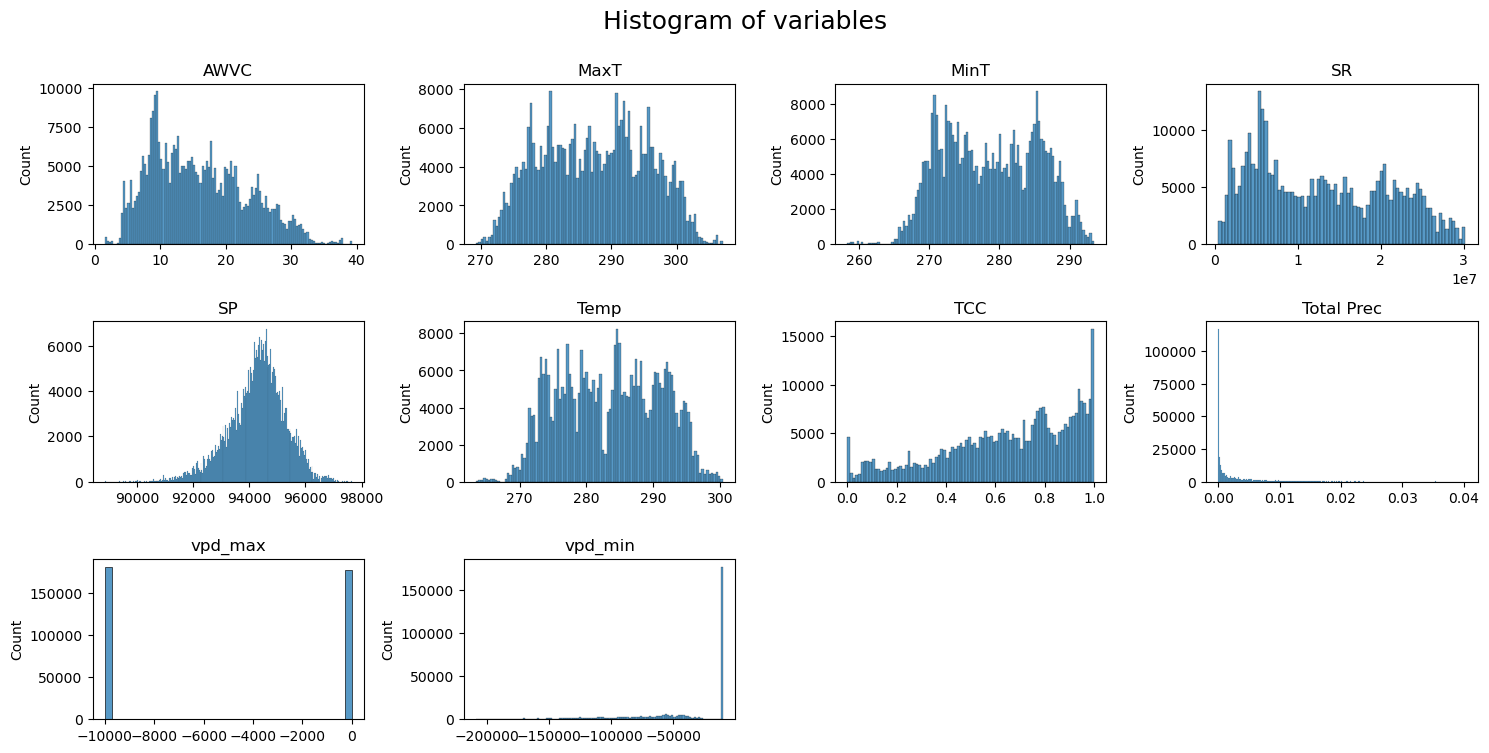

In [7]:
#bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8a", "B11", "B12", "NDVI"] #, "SCL", "CP", "NDWI", "NDMI", "MSI", "NDVIre"]
bands = ["AWVC", "MaxT", "MinT", "SR", "SP", "Temp", "TCC", "Total Prec", "vpd_max", "vpd_min"]

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Histogram of variables", fontsize=18, y=1)

cp_search = '\[' +  'CP' + '\]'
    
for n, band in enumerate(bands):
    print(band)
    band_data = np.array([])
    to_search = '\[' +  band + '\]'
    for folder in os.listdir(data_path):
        if folder in complete_folders: #jura region, complete data
            for file in os.listdir(data_path + '/' + folder):
                if (file.endswith('.tiff') & bool(re.search(f'{to_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        data = src.read(1)
                    band_sample = [data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                """
                if (file.endswith('.tiff') & bool(re.search(f'{cp_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        cloud = src.read(1)
                    cloud_sample = [cloud[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                """

            # Mask out forest, clouds and -9999 (as nan)
            """
            band_sample = np.array(band_sample)
            cloud_sample = np.array(cloud_sample)
            band_sample[band_sample == -9999] = np.nan
            band_sample[cloud_sample>=cp_thresh] = np.nan 
            """
            band_data = np.append(band_data, band_sample)
            #band_data = np.append(band_data, band_sample[~np.isnan(band_sample)])
    print(band_data.shape)
    
    # Plot
    ax = plt.subplot(5, 4, n+1) #int(f'54{n + 1}') hsould add a sharey here
    sns.histplot(ax=ax, data=band_data[~np.isnan(band_data)])
    ax.set_title(f'{band}')

plt.tight_layout()

#### Boxplots (only for s2 since ERA5 variables hav very different ranges)

In [8]:
data_path = SEN_PATH
cp_thresh = 50

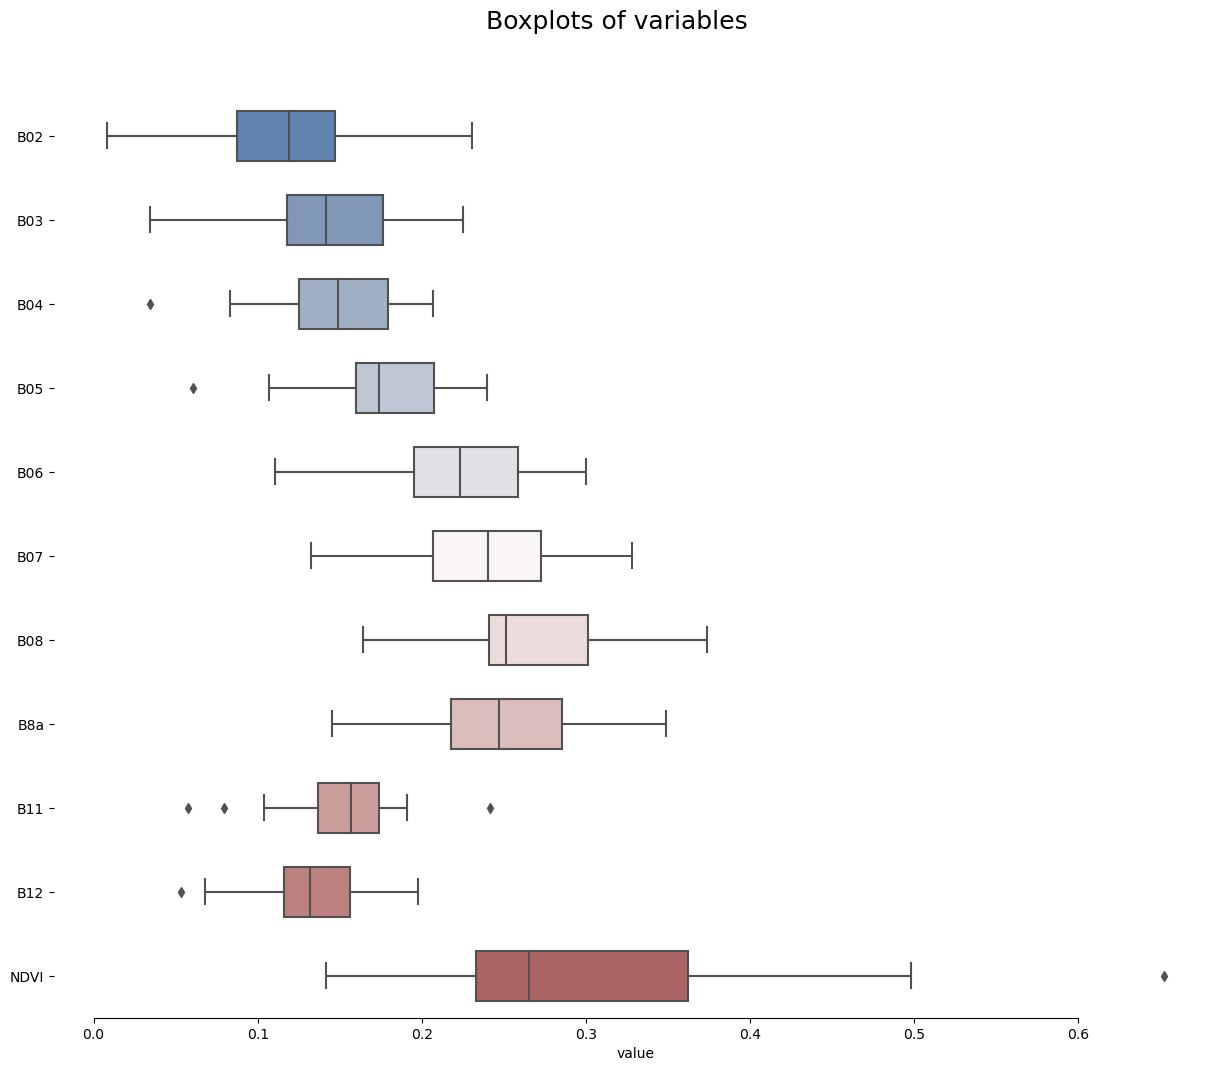

In [9]:
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8a", "B11", "B12", "NDVI"]#, "SCL", "CP", "NDWI", "NDMI", "MSI", "NDVIre"]

fig, ax = plt.subplots(1, 1, figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Boxplots of variables", fontsize=18, y=0.95)

df = pd.DataFrame()
cp_search = '\[' +  'CP' + '\]'

for n, band in enumerate(bands):
    band_data = np.array([])
    to_search = '\[' +  band + '\]'
    for folder in os.listdir(data_path):
        if folder in complete_folders: #jura region, complete data
            for file in os.listdir(data_path + '/' + folder):
                if (file.endswith('.tiff') & bool(re.search(f'{to_search}',file))):
                    
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        data = src.read(1)
                    band_sample = [data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    band_data = np.append(band_data, band_sample)
  
                if (file.endswith('.tiff') & bool(re.search(f'{cp_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        cloud = src.read(1)
                    cloud_sample = [cloud[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]

                    
            # Mask out forest, clouds and -9999 (as nan)
            band_sample = np.array(band_sample)
            cloud_sample = np.array(cloud_sample)
            cloud_sample[cloud_sample==-9999] = np.nan
            band_sample[band_sample == -9999] = np.nan
            band_sample[cloud_sample>=cp_thresh] = np.nan 


            #df_tmp = pd.DataFrame({'band': [band]*len(band_data) , 'value': band_data})
            df_tmp = pd.DataFrame({'band': [band]*len(band_sample) , 'value': band_sample, 'cp':cloud_sample})
            df_tmp = df_tmp.dropna(axis=0)
    
    df = pd.concat([df, df_tmp], ignore_index=True)

    
# Plot the orbital period with horizontal boxes
sns.boxplot(x="value", y="band", data=df[df.value!=-9999], width=.6, palette="vlag")

# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

#### Cloudy days
Look at CP and check number of pixels in image has over 50% probability of being covered by cloud.\
Save the date of cloudy image

In [109]:
data_path = SEN_PATH

In [115]:
# Only look at CP file
df_clouds = pd.DataFrame()

for folder in os.listdir(data_path):
    if folder in complete_folders: #jura region, complete data
        timestamp = datetime.strptime(folder.split('Z')[0], '%Y-%m-%dT%H:%M:%S')
        for file in os.listdir(data_path + '/' + folder):
            if (file.endswith('.tiff') & ('CP' in file)):
                with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                    arr = src.read(1)
                # count total nbr pixels
                #n_pixs = sum(not np.isnan(x) for x in arr.flatten())
                # count nbr pixels with CP>0.5
                n_cloud = (arr>0.5).sum()
                df_tmp = pd.DataFrame({'timestamp': [timestamp] , 'n_cloud': [n_cloud]})
    
        df_clouds = pd.concat([df_clouds, df_tmp], ignore_index=True)

In [116]:
df_clouds

timestamp  n_cloud
0   2020-07-28  2600312
1   2015-11-17  3627545
2   2019-12-21  3686817
3   2015-09-08   122111
4   2019-08-18    38356
..         ...      ...
381 2018-05-20  2888846
382 2015-12-07  1419542
383 2020-02-24   325396
384 2021-07-18  1383071
385 2018-01-15  3813680

[386 rows x 2 columns]

In [117]:
# Total number of pixels
for folder in os.listdir(data_path):
    if folder in complete_folders: #jura region, complete data
        timestamp = datetime.strptime(folder.split('Z')[0], '%Y-%m-%dT%H:%M:%S')
        for file in os.listdir(data_path + '/' + folder):
            if (file.endswith('.tiff') & ('CP' in file)):
                with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                    arr = src.read(1)
                print((arr!=np.nan).sum())
                tot_cloud = (arr!=np.nan).sum()
                break
        break

3841600


In [118]:
# Calculate ratio of clouds in image
df_clouds['ratio_cloudy'] = df_clouds['n_cloud']/tot_cloud

'\nfig, ax = plt.subplots(1,1, figsize=(7,4))\nsns.histplot(ax=ax, data=df_clouds[\'ratio_cloudy\'], color=\'#22518A\')  #25548B\nplt.xlabel("Ratio of image covered by clouds")\nplt.title("Distribution of ratio of image that is clouded")\n'

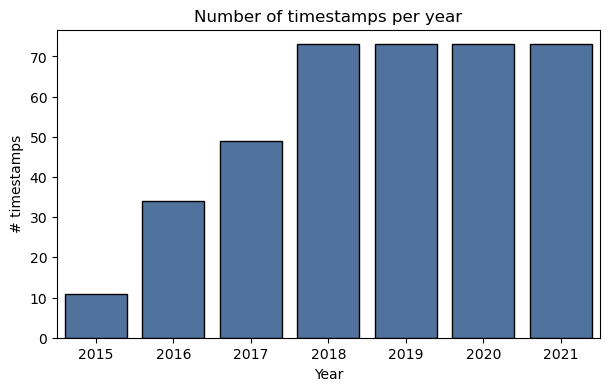

In [140]:
palette = sns.color_palette("tab10")
col = '#4372AB'
fig, ax = plt.subplots(1,1, figsize=(7,4))
ax.grid(False)
sns.barplot(ax=ax, data=times_per_yr, x="timestamp", y="folder", color='#4372AB', edgecolor='black')
plt.title('Number of timestamps per year')
plt.ylabel('# timestamps')
plt.xlabel('Year')
"""
fig, ax = plt.subplots(1,1, figsize=(7,4))
sns.histplot(ax=ax, data=df_clouds['ratio_cloudy'], color='#22518A')  #25548B
plt.xlabel("Ratio of image covered by clouds")
plt.title("Distribution of ratio of image that is clouded")
"""

Text(0.5, 1.0, 'Evolution of image cloudiness')

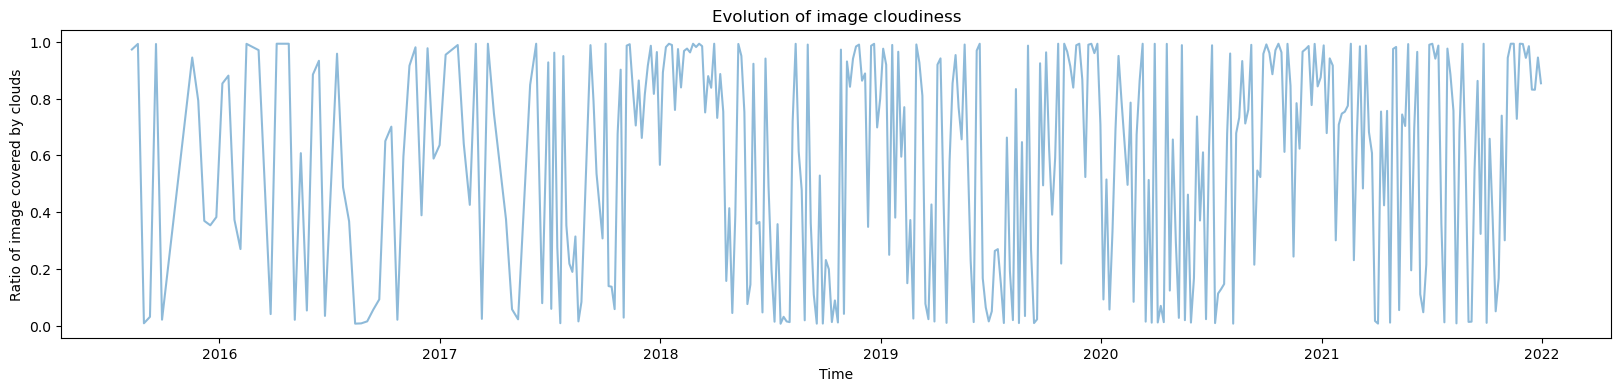

In [11]:
# Temporal evolution of cloud ratio
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1,1, figsize=(20,4))
sns.lineplot(ax=ax, x='timestamp', y='ratio_cloudy', data=df_clouds, alpha=0.5)
#sns.scatterplot(ax=ax, x='timestamp', y='ratio_cloudy', data=df_clouds, color='red')
plt.ylabel("Ratio of image covered by clouds")
plt.xlabel("Time")
plt.title("Evolution of image cloudiness")

#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m'))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(200))

NameError: name 'df_clouds' is not defined

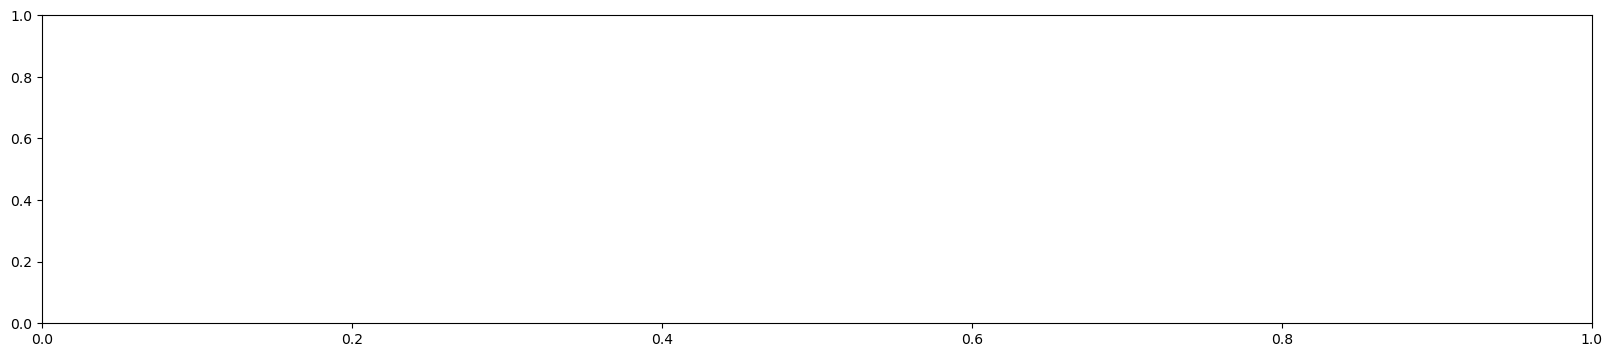

In [15]:
# Temporal evolution of cloud ratio
#df_clouds['year'] = df_clouds['timestamp'].apply(lambda x: x.year)
#df_clouds['week'] = df_clouds['timestamp'].apply(lambda x: x.week)
#df_clouds['day'] = df_clouds['timestamp'].apply(lambda x: x.dayofyear)

fig, ax = plt.subplots(1,1, figsize=(20,4))
sns.lineplot(ax=ax, x='timestamp', y='ratio_cloudy', data=df_clouds, hue='year', ci=None)
sns.scatterplot(ax=ax, x='timestamp', y='ratio_cloudy', data=df_clouds)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

# ERA timeseries

In [51]:
complete_folders_era = []
data_path = '/dccstor/cimf/drought_impact/downloads/ERA5/'
for folder in os.listdir(data_path):
    if '46.907_7.137_47.407_7.637' in folder:
        filelist = [file for file in os.listdir(data_path+folder) if file.endswith('.tiff')]
        if len(filelist)>=10:
            complete_folders_era.append(folder)

In [52]:
len(complete_folders_era)

567

In [53]:
data_path = ERA_PATH
bands = ["AWVC", "MaxT", "MinT", "SR", "SP", "Temp", "TCC", "Total Prec", "vpd_max", "vpd_min"]
df_ERA = pd.DataFrame()

for n, band in enumerate(bands):
    print(band)
    band_data = np.array([])
    to_search = '\[' +  band + '\]'
    for folder in os.listdir(data_path):
        if folder in complete_folders_era: #jura region
            for file in os.listdir(data_path + '/' + folder):
                if (file.endswith('.tiff') & bool(re.search(f'{to_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        data = src.read(1)
                    band_sample = [data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    band_data = np.append(band_data, band_sample)
            
            df_tmp = pd.DataFrame({'band': [band]*len(band_data) , 'value': band_data})
    
    df_ERA = pd.concat([df_ERA, df_tmp], ignore_index=True)

AWVC


NameError: name 'for_pixs' is not defined

In [6]:
"""
with open('df_ERA.pkl', 'wb') as f:
    pickle.dump(df_ERA, f)
"""
with open('df_ERA.pkl', 'rb') as f:
    df_ERA = pickle.load(f)


In [10]:
# Add timeseries
data_path= ERA_PATH
list_times = list()
for folder in os.listdir(data_path):
    if folder in complete_folders_era: #jura region, complete data
        timestamp = datetime.strptime(folder.split('T')[0], '%Y-%m-%d')
        list_times.append(timestamp)

bands = ["AWVC", "MaxT", "MinT", "SR", "SP", "Temp", "TCC", "Total Prec", "vpd_max", "vpd_min"]

list_times = list(itertools.chain.from_iterable(itertools.repeat(x, 1000) for x in list_times)) # Repeat for 1000 pixels
list_times = list(itertools.chain.from_iterable(itertools.repeat(x, len(bands)) for x in list_times)) # Repeat for all bands
df_ERA['ts']=list_times
df_ERA = df_ERA.sort_values('ts')
df_ERA.head()

band       value         ts
1929996   SR  23093216.0 2015-08-09
1923332   SR  13330592.0 2015-08-09
1923331   SR  15230605.0 2015-08-09
1923330   SR  13931556.0 2015-08-09
1923329   SR  14501578.0 2015-08-09

In [18]:
np.unique(df_ERA.ts)

array(['2015-08-09T00:00:00.000000000', '2015-08-10T00:00:00.000000000',
       '2015-08-11T00:00:00.000000000', '2015-08-19T00:00:00.000000000',
       '2015-08-20T00:00:00.000000000', '2015-08-21T00:00:00.000000000',
       '2015-08-29T00:00:00.000000000', '2015-08-30T00:00:00.000000000',
       '2015-08-31T00:00:00.000000000', '2015-09-01T00:00:00.000000000',
       '2015-09-08T00:00:00.000000000', '2015-09-09T00:00:00.000000000',
       '2015-09-10T00:00:00.000000000', '2015-09-18T00:00:00.000000000',
       '2015-09-19T00:00:00.000000000', '2015-09-20T00:00:00.000000000',
       '2015-09-21T00:00:00.000000000', '2015-09-22T00:00:00.000000000',
       '2015-09-23T00:00:00.000000000', '2015-09-28T00:00:00.000000000',
       '2015-09-29T00:00:00.000000000', '2015-09-30T00:00:00.000000000',
       '2015-11-17T00:00:00.000000000', '2015-11-18T00:00:00.000000000',
       '2015-11-19T00:00:00.000000000', '2015-11-27T00:00:00.000000000',
       '2015-11-28T00:00:00.000000000', '2015-11-29

In [12]:
# Extract data on time
df_ERA['year'] = df_ERA.ts.apply(lambda x: x.year)
df_ERA['day'] = df_ERA.ts.apply(lambda x: x.dayofyear)
df_ERA['month'] = df_ERA.ts.apply(lambda x: x.month)

Text(0.5, 0, '')

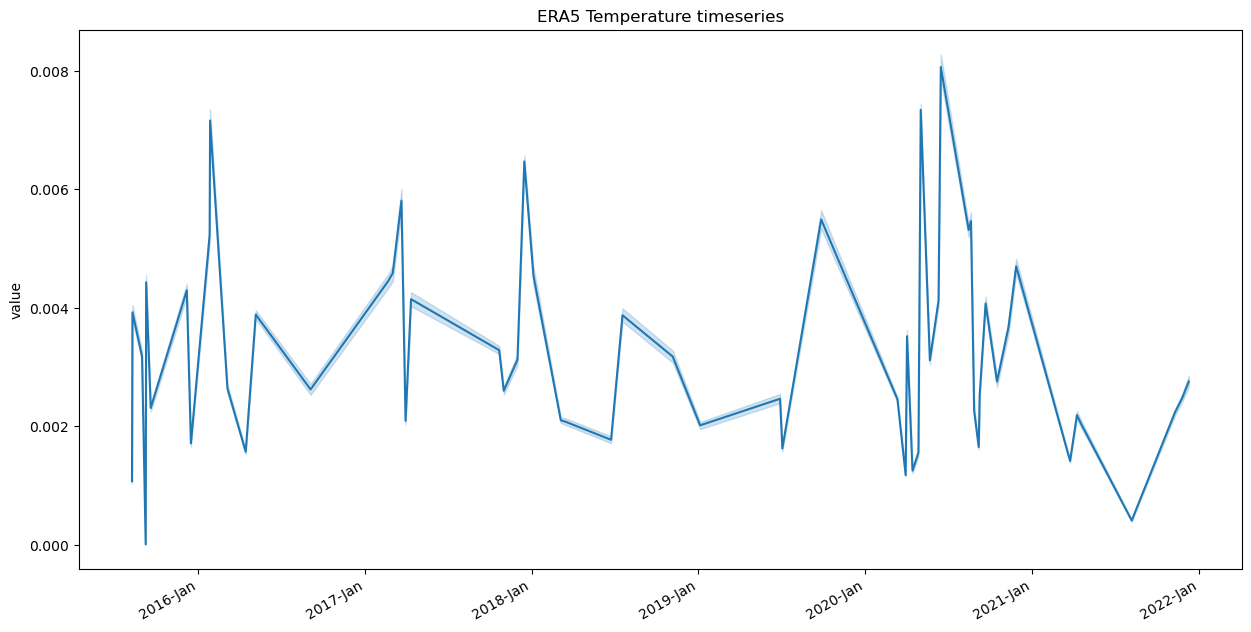

In [19]:
# All bands timeseries
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plt.title('ERA5 Temperature timeseries')
sns.lineplot(ax=ax, x='ts', y='value', data=df_ERA[df_ERA.band=='Total Prec'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')

### Using a queried point from PAIRS

In [54]:
df_pt = pd.read_csv('era5_point.txt', sep=",")
layer_ids = {49423:"Temp", 49439:"SP", 49440:"SR", 49458:"AWVC", 49459:"Total Prec"}
df_pt["layer"] = df_pt["dataLayerId"].map(layer_ids)
df_pt['dateTime']= pd.to_datetime(df_pt['dateTime'])

In [55]:
# Extract data on time
df_pt['year'] = df_pt.dateTime.apply(lambda x: x.year)
df_pt['day'] = df_pt.dateTime.apply(lambda x: x.dayofyear)
df_pt['week'] = df_pt.dateTime.apply(lambda x: x.week)
df_pt['month'] = df_pt.dateTime.apply(lambda x: x.month)

/tmp/ipykernel_230302/2485794241.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_pt['week'] = df_pt.dateTime.apply(lambda x: x.week)


In [56]:
idx_drop = df_pt[df_pt.year==2022].index
df_pt = df_pt.drop(idx_drop, axis=0)

In [57]:
df_pt

dataLayerId                  dateTime         value layer  year  day  \
0             49439 2015-01-09 01:00:00+00:00  95639.835938    SP  2015    9   
1             49439 2015-01-09 02:00:00+00:00  95602.960938    SP  2015    9   
2             49439 2015-01-09 03:00:00+00:00  95577.960938    SP  2015    9   
3             49439 2015-01-09 04:00:00+00:00  95521.546875    SP  2015    9   
4             49439 2015-01-09 05:00:00+00:00  95477.156250    SP  2015    9   
...             ...                       ...           ...   ...   ...  ...   
306642        49440 2021-12-31 19:00:00+00:00      0.000000    SR  2021  365   
306643        49440 2021-12-31 20:00:00+00:00      0.000000    SR  2021  365   
306644        49440 2021-12-31 21:00:00+00:00      0.000000    SR  2021  365   
306645        49440 2021-12-31 22:00:00+00:00      0.000000    SR  2021  365   
306646        49440 2021-12-31 23:00:00+00:00      0.000000    SR  2021  365   

        week  month  
0          2      1  
1          2      1  
2          2      1  
3          2      1  
4          2      1  
...      ...    ...  
306642    52     12  
306643    52     12  
306644    52     12  
306645    52     12  
306646    52     12  

[305875 rows x 8 columns]

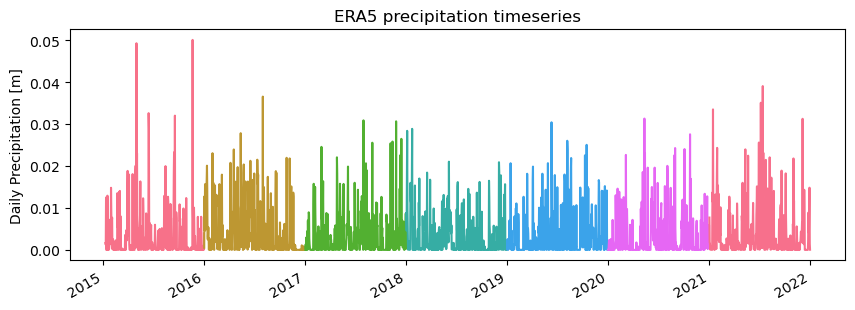

In [29]:
# Precipitation: convert to daily data
daily_pt = df_pt[df_pt.layer=='Total Prec'].groupby(['year','month','day']).sum().value.reset_index()
daily_pt['dateTime'] = df_pt.drop_duplicates(['year','month','day'], keep='first').dateTime.tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.title('ERA5 precipitation timeseries')
sns.lineplot(ax=ax, x='dateTime', y='value', data=daily_pt, palette='husl', hue='year')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')
plt.ylabel('Daily Precipitation [m]')
ax.get_legend().remove()

AttributeError: 'NoneType' object has no attribute 'remove'

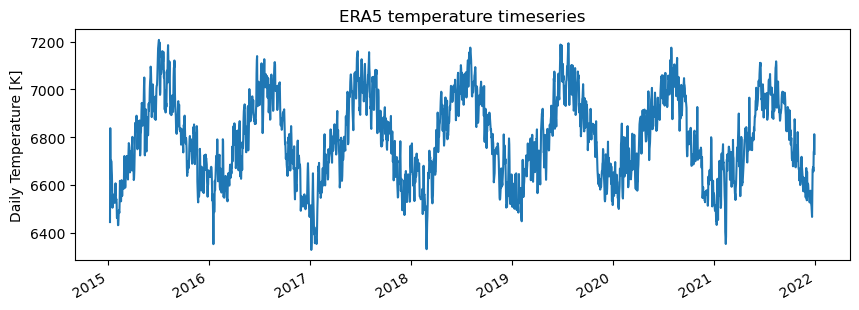

In [31]:
# Temperature
daily_pt = df_pt[df_pt.layer=='Temp'].groupby(['year','month','day']).sum().value.reset_index()
daily_pt['dateTime'] = df_pt.drop_duplicates(['year','month','day'], keep='first').dateTime.tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.title('ERA5 temperature timeseries')
sns.lineplot(ax=ax, x='dateTime', y='value', data=daily_pt) #, palette='husl', hue='year')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')
plt.ylabel('Daily Temperature [K]')
ax.get_legend().remove()

AttributeError: 'NoneType' object has no attribute 'remove'

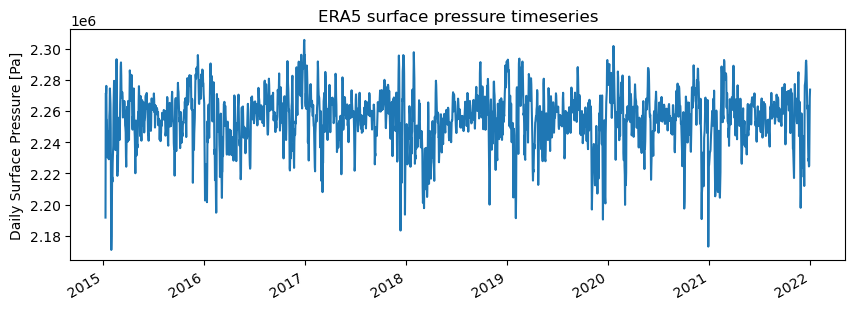

In [35]:
# Surface Pressure
daily_pt = df_pt[df_pt.layer=='SP'].groupby(['year','month','day']).sum().value.reset_index()
daily_pt['dateTime'] = df_pt.drop_duplicates(['year','month','day'], keep='first').dateTime.tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.title('ERA5 surface pressure timeseries')
sns.lineplot(ax=ax, x='dateTime', y='value', data=daily_pt)#, palette='husl', hue='year')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')
plt.ylabel('Daily Surface Pressure [Pa]')
ax.get_legend().remove()

AttributeError: 'NoneType' object has no attribute 'remove'

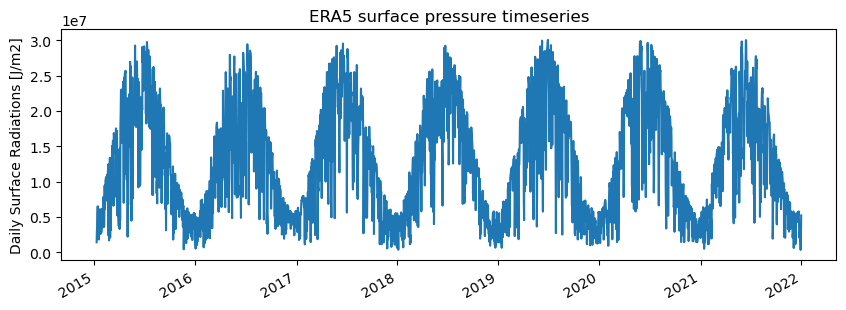

In [37]:
# Solar radiation
daily_pt = df_pt[df_pt.layer=='SR'].groupby(['year','month','day']).sum().value.reset_index()
daily_pt['dateTime'] = df_pt.drop_duplicates(['year','month','day'], keep='first').dateTime.tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.title('ERA5 surface pressure timeseries')
sns.lineplot(ax=ax, x='dateTime', y='value', data=daily_pt)#, palette='husl', hue='year')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')
plt.ylabel('Daily Surface Radiations [J/m2]')
ax.get_legend().remove()

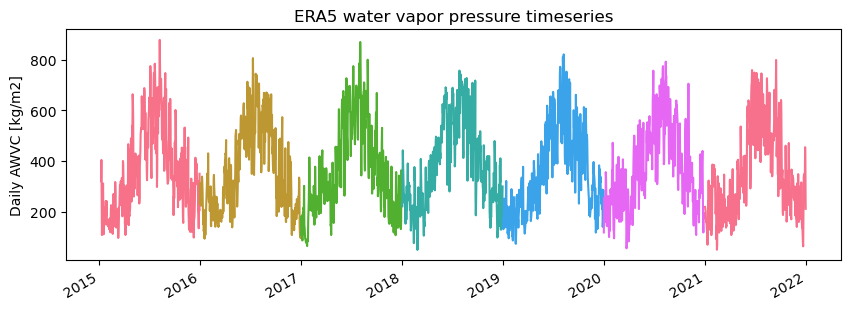

In [40]:
# AWVC
daily_pt = df_pt[df_pt.layer=='AWVC'].groupby(['year','month','day']).sum().value.reset_index()
daily_pt['dateTime'] = df_pt.drop_duplicates(['year','month','day'], keep='first').dateTime.tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.title('ERA5 water vapor pressure timeseries')
sns.lineplot(ax=ax, x='dateTime', y='value', data=daily_pt, palette='husl', hue='year')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')
plt.ylabel('Daily AWVC [kg/m2]')
ax.get_legend().remove()

Text(0, 0.5, 'Daily temperature [K]')

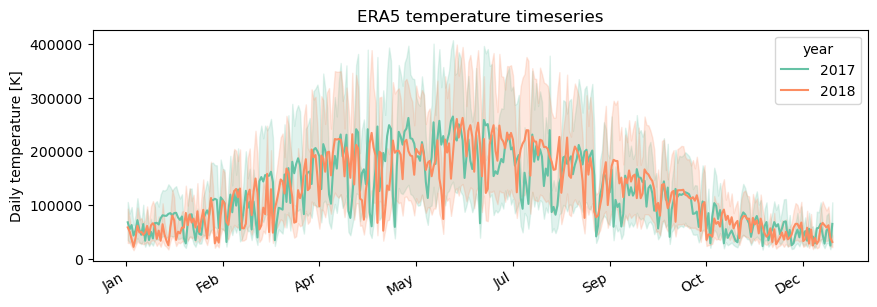

In [48]:
# Compare years
daily_pt = df_pt[df_pt.layer=='Temp'].groupby(['year','month','day']).sum().value.reset_index()
daily_pt['dateTime'] = df_pt.drop_duplicates(['year','month','day'], keep='first').dateTime.tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
plt.title('ERA5 temperature timeseries')
sns.lineplot(ax=ax, x='day', y='value', data=df_pt[df_pt.year.isin([2017,2018])], palette='Set2', hue='year')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')
plt.ylabel('Daily temperature [K]')

Text(0, 0.5, 'Daily percipitation [m]')

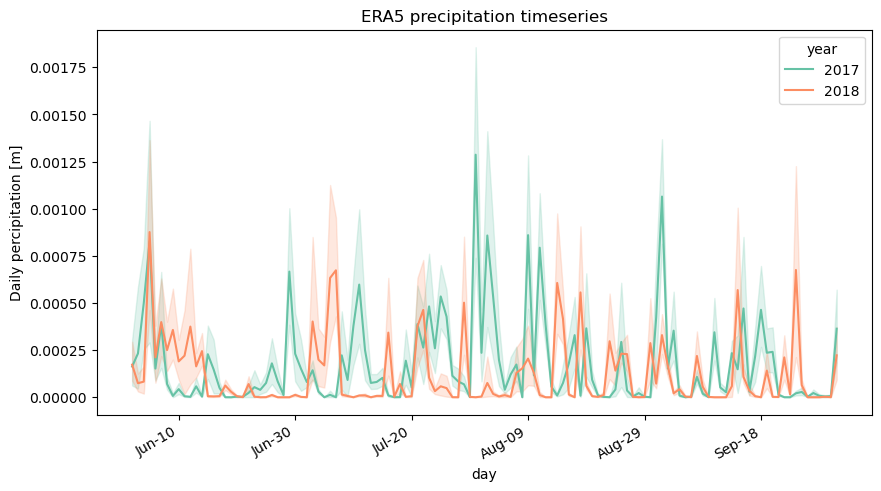

In [62]:
# Compare years
daily_pt = df_pt[df_pt.layer=='Total Prec'].groupby(['year','month','day']).sum().value.reset_index()
daily_pt['dateTime'] = df_pt.drop_duplicates(['year','month','day'], keep='first').dateTime.tolist()


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('ERA5 precipitation timeseries')
sns.lineplot(ax=ax, x='day', y='value', hue='year', data=df_pt[(df_pt.layer=='Total Prec') & (df_pt.year.isin([2017,2018])) & (df_pt.month.isin([6,7,8,9]))], palette='Set2')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.ylabel('Daily percipitation [m]')

Text(0, 0.5, 'Daily surface pressure [Pa]')

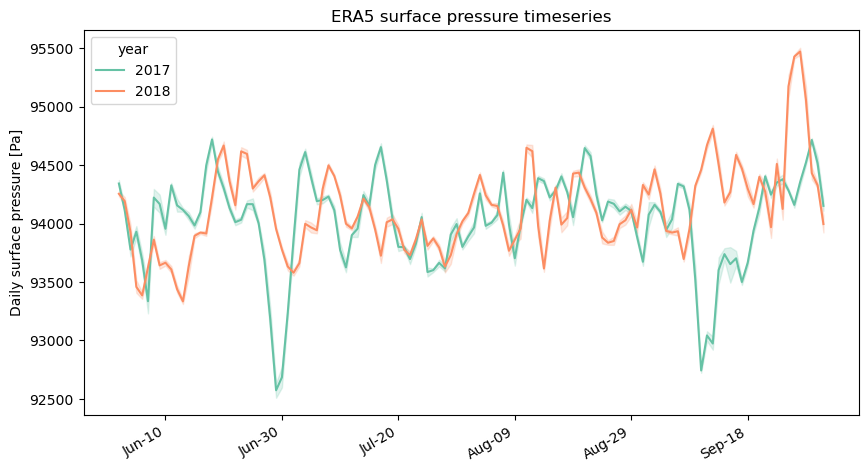

In [63]:
# Compare years
daily_pt = df_pt[df_pt.layer=='SP'].groupby(['year','month','day']).sum().value.reset_index()
daily_pt['dateTime'] = df_pt.drop_duplicates(['year','month','day'], keep='first').dateTime.tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('ERA5 surface pressure timeseries')
sns.lineplot(ax=ax, x='day', y='value', hue='year', data=df_pt[(df_pt.layer=='SP') & (df_pt.year.isin([2017,2018])) & (df_pt.month.isin([6,7,8,9]))], palette='Set2')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')
plt.ylabel('Daily surface pressure [Pa]')

Text(0.5, 0, '')

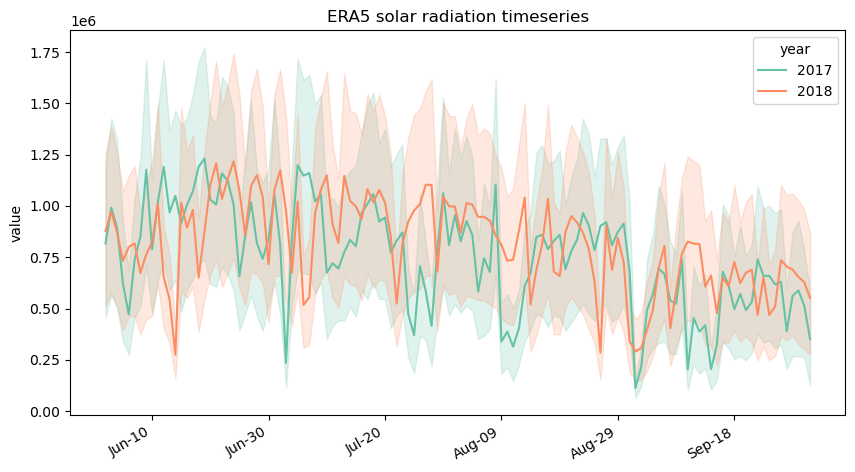

In [64]:
# Compare years
daily_pt = df_pt[df_pt.layer=='SR'].groupby(['year','month','day']).sum().value.reset_index()
daily_pt['dateTime'] = df_pt.drop_duplicates(['year','month','day'], keep='first').dateTime.tolist()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('ERA5 solar radiation timeseries')
sns.lineplot(ax=ax, x='day', y='value', hue='year', data=df_pt[(df_pt.layer=='SR') & (df_pt.year.isin([2017,2018])) & (df_pt.month.isin([6,7,8,9]))], palette='Set2')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')

Text(0.5, 0, '')

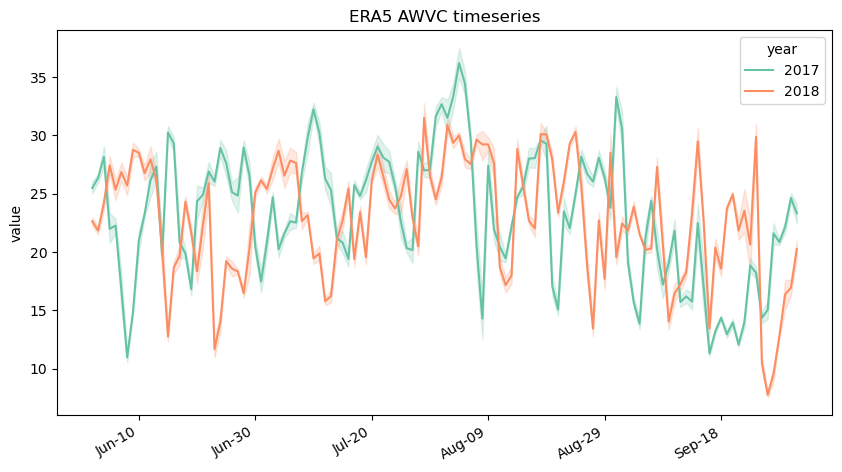

In [65]:
# Compare years
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('ERA5 AWVC timeseries')
sns.lineplot(ax=ax, x='day', y='value', hue='year', data=df_pt[(df_pt.layer=='AWVC') & (df_pt.year.isin([2017,2018])) & (df_pt.month.isin([6,7,8,9]))], palette='Set2')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')

# ERA mean vs median 
- Get yearly hourly timeseries for a point
- Groupby 1/5/10-daily and location ( add 1000 nbrs repeatedly)
- Compute mean and median 
- Calculate % difference from median (mean-median)/median

In [31]:
df_hourly = pd.read_csv('hourly_era_pt.txt', sep=",")
layer_ids = {49423:"Temp", 49439:"SP", 49458:"AWVC", 49454:"TCC"}
df_hourly["layer"] = df_hourly["dataLayerId"].map(layer_ids)
df_hourly['dateTime']= pd.to_datetime(df_hourly['dateTime'])

In [32]:
df_hourly = df_hourly.set_index("dateTime")

In [34]:
means = df_hourly.groupby("layer").resample("D").mean().reset_index()
means['meds'] = df_hourly.groupby("layer").resample("D").median().reset_index().value

In [49]:
# Compute \% difference
means['diff'] = (means['value']-means['meds'])*100/means['value']

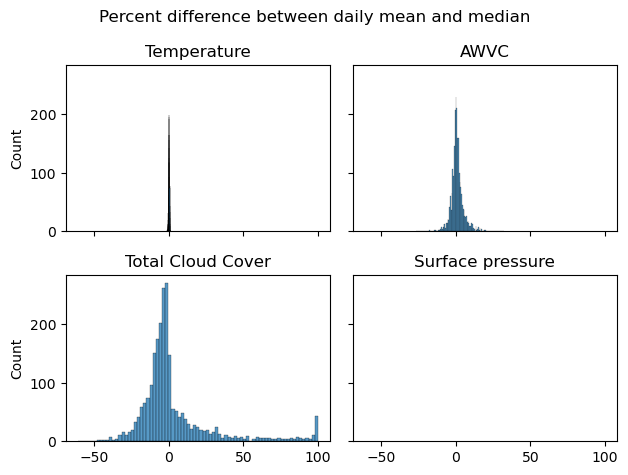

In [50]:
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)
plt.suptitle('Percent difference between daily mean and median')
# Plot histograms on each subplot
sns.histplot(data=means[means.layer=='Temp'], x='diff', ax=axs[0][0])
sns.histplot(data=means[means.layer=='AWVC'], x='diff',ax=axs[0][1])
sns.histplot(data=means[means.layer=='TCC'], x='diff', ax=axs[1][0])
sns.histplot(data=means[means.layer=='SP'], x='diff', ax=axs[1][1])

axs[0][0].set(title = 'Temperature', xlabel = '')
axs[0][1].set(title = 'AWVC', xlabel = '')
axs[1][0].set(title = 'Total Cloud Cover', xlabel = '')
axs[1][1].set(title = 'Surface pressure', xlabel = '')

plt.tight_layout()
# Show the plot
plt.show()

In [51]:
from scipy.stats import ranksums

# Statistical test
for band in np.unique(means.layer):
    data = means[means.layer==band]
    stat, p_value = ranksums(data['value'], data['meds'])
    if p_value<0.05:
        print(f'Reject null hypothesis that two samples are from same distribution.\n Mean and median are statistically different for {band}')
    if p_value>0.05:
        print(f'Cannot reject null hypothesis that two samples are from same distribution.\n Mean and median are NOT statistically different for {band}')

Cannot reject null hypothesis that two samples are from same distribution.
 Mean and median are NOT statistically different for AWVC
Cannot reject null hypothesis that two samples are from same distribution.
 Mean and median are NOT statistically different for SP
Reject null hypothesis that two samples are from same distribution.
 Mean and median are statistically different for TCC
Cannot reject null hypothesis that two samples are from same distribution.
 Mean and median are NOT statistically different for Temp


# Heatmap/correlation

In [146]:
# USING SAME DF AS IN BOXPLOTS
bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8a", "B11", "B12", "NDVI"]#, "SCL", "CP", "NDWI", "NDMI", "MSI", "NDVIre"]
#bands = ["AWVC", "MaxT", "MinT", "SR", "SP", "Temp", "TCC", "Total Prec", "vpd_max", "vpd_min"]
data_path = SEN_PATH
df = pd.DataFrame()

for n, band in enumerate(bands):
    print(band)
    band_data = np.array([])
    to_search = '\[' +  band + '\]'
    for folder in os.listdir(data_path):
        if folder in complete_folders_jura: #jura region, complete data
            for file in os.listdir(data_path + '/' + folder):
                if (file.endswith('.tiff') & bool(re.search(f'{to_search}',file))):
                    """
                    im = gdal.Open(data_path + '/' + folder + '/' + file)
                    # Mask out non forest pixels
                    arr = np.array(im.GetRasterBand(1).ReadAsArray())
                    masked_arr = arr[forest_binary50]
                    # Keep 1000 first forest pixels
                    masked_arr = masked_arr[for_pixs]
                    """
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        data = src.read(1)
                    band_sample = [data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    band_data = np.append(band_data, band_sample)
                    
        # Replace -9999 with nan
        band_data[band_data==-9999] = np.nan
        df_tmp = pd.DataFrame({'band': [band]*len(band_data) , 'value': band_data})

    df = pd.concat([df, df_tmp], ignore_index=True)
    print(df.shape)

B02
(386000, 2)
B03
(772000, 2)
B04
(1158000, 2)
B05
(1544000, 2)
B06
(1930000, 2)
B07
(2316000, 2)
B08
(2702000, 2)
B8a
(3088000, 2)
B11
(3474000, 2)
B12
(3860000, 2)
NDVI
(4246000, 2)


In [147]:
df.groupby('band').size() # if you use .count() it skips nan

band
B02     386000
B03     386000
B04     386000
B05     386000
B06     386000
B07     386000
B08     386000
B11     386000
B12     386000
B8a     386000
NDVI    386000
dtype: int64

In [18]:
"""
with open('/dccstor/cimf/drought_impact/DEM/dem_tests/df_heat_s2.pkl', 'wb') as f:
    pickle.dump(df, f)


# ERA
with open('/dccstor/cimf/drought_impact/DEM/dem_tests/df_heat.pkl', 'wb') as f:
    pickle.dump(df, f)
"""
with open('df_heat.pkl', 'rb') as f:
    df = pickle.load(f)


In [19]:
for group_id, rows in df.groupby('band'):
    print(rows['value'].values)
    #df_bands_ts[f"{group_id}"] = rows['value']  
    break

[30.50567818 30.41974449 30.4197464  ...  9.40956402  9.61982822
 10.04609585]


In [23]:
# Make df wide and add time series

df_bands_ts = pd.DataFrame()
for group_id, rows in df.groupby('band'):
    df_bands_ts[f"{group_id}"] = rows['value'].values.tolist()                             
                    
data_path = ERA_PATH
list_times = list()
for folder in os.listdir(data_path):
    if folder in complete_folders_jura: #jura region, complete data
        timestamp = datetime.strptime(folder.split('T')[0], '%Y-%m-%d')
        list_times.append(timestamp)

list_times = list(itertools.chain.from_iterable(itertools.repeat(x, 1000) for x in list_times))
df_bands_ts['ts']=list_times

In [24]:
df_bands_ts

AWVC        MaxT        MinT            SP          SR       TCC  \
0       30.505678  300.891296  291.930817  94192.601562  21915016.0  0.319946   
1       30.419744  301.226227  292.111664  94468.804688  21887882.0  0.294528   
2       30.419746  301.226227  292.111664  94468.812500  21887884.0  0.294528   
3       28.230480  299.378662  288.930237  91807.578125  22130596.0  0.360992   
4       31.222950  301.327240  292.141266  94705.921875  21551514.0  0.357198   
...           ...         ...         ...           ...         ...       ...   
359995   8.837736  279.052795  269.462494  93490.546875   5445044.0  0.709544   
359996  10.123785  280.034698  270.231110  95252.164062   4813519.0  0.778774   
359997   9.409564  279.315491  270.442169  93996.679688   5176815.5  0.734586   
359998   9.619828  279.359894  270.331268  93923.968750   5031792.0  0.739433   
359999  10.046096  279.401276  270.369141  94031.929688   4805804.0  0.728422   

              Temp  Total Prec  vpd_max       vpd_min         ts  
0       296.740753    0.002485      NaN           NaN 2020-07-28  
1       296.901215    0.001773      NaN           NaN 2020-07-28  
2       296.901184    0.001773      NaN           NaN 2020-07-28  
3       295.164581    0.011122      NaN           NaN 2020-07-28  
4       296.729797    0.003895      NaN           NaN 2020-07-28  
...            ...         ...      ...           ...        ...  
359995  274.595764    0.002120      0.0 -40391.527344 2018-01-15  
359996  275.564331    0.002863      0.0 -43573.804688 2018-01-15  
359997  275.285431    0.002420      0.0 -43461.648438 2018-01-15  
359998  275.277191    0.002507      0.0 -43104.035156 2018-01-15  
359999  275.394196    0.003086      0.0 -43225.859375 2018-01-15  

[360000 rows x 11 columns]

In [ ]:
# Plot a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
df_new = df_bands_ts
sns.heatmap(df_new.corr(), linewidths=.5, ax=ax, annot=True, fmt=".1f", center=0, vmax=1, vmin=-1)

<AxesSubplot:>

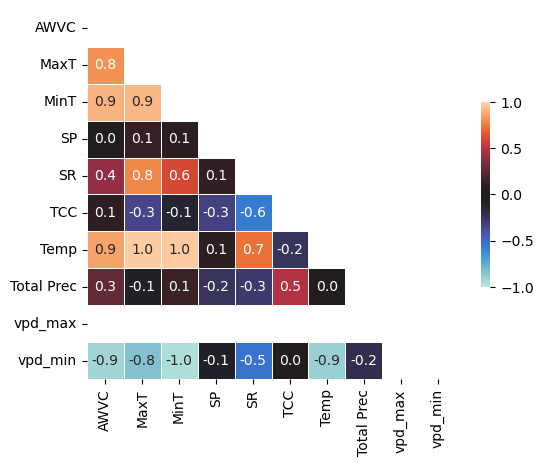

In [21]:
# Generate a mask for the upper triangle
mask_tri = np.triu(np.ones_like(df_bands_ts.corr(), dtype=bool))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_bands_ts.corr(), mask=mask_tri,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f", center=0, vmax=1, vmin=-1)

### ERA

In [27]:
# Get NDVI and CP

# USING SAME DF AS IN BOXPLOTS
bands = ["NDVI"]#, "SCL", "CP", "NDWI", "NDMI", "MSI", "NDVIre"]
data_path = SEN_PATH
df_NDVI = pd.DataFrame()

for n, band in enumerate(bands):
    band_data = np.array([])
    cp_data = np.array([])
    b2_data = np.array([])
    b8_data = np.array([])
    to_search = '\[' +  band + '\]'
    cp_search =  '\[' + 'CP' + '\]'
    b2_search = '\[' + 'B02' + '\]'
    b8_search = '\[' + 'B08' + '\]'
    for folder in os.listdir(data_path):
        if folder in complete_folders_jura: #jura region, complete data
            for file in os.listdir(data_path + '/' + folder):
                if (file.endswith('.tiff') & bool(re.search(f'{to_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        data = src.read(1)
                    band_sample = [data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    band_data = np.append(band_data, band_sample)
                if (file.endswith('.tiff') & bool(re.search(f'{cp_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        cp = src.read(1)
                    cp_sample = [cp[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    cp_data = np.append(cp_data, cp_sample)
                    
                if (file.endswith('.tiff') & bool(re.search(f'{b2_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        blue = src.read(1)
                    blue_sample = [blue[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    b2_data = np.append(b2_data, blue_sample)
                    
                if (file.endswith('.tiff') & bool(re.search(f'{b8_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        infrared = src.read(1)
                    infr_sample = [infrared[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    b8_data = np.append(b8_data, infr_sample)
                    
        # Replace -9999 with nan
        band_data[band_data==-9999] = np.nan
        cp_data[cp_data==-9999] = np.nan
        df_tmp = pd.DataFrame({'band': [band]*len(band_data) , 'value': band_data, 'cp':cp_data, 'b2':b2_data, 'b8':b8_data})

    df_NDVI = pd.concat([df_NDVI, df_tmp], ignore_index=True)
    
    
df_bands_ts_NDVI = pd.DataFrame()
for group_id, rows in df_NDVI.groupby('band'):
    df_bands_ts_NDVI[f"{group_id}"] = rows['value'].values.tolist() 
df_bands_ts_NDVI['cp'] = df_NDVI.cp
df_bands_ts_NDVI['b2'] = df_NDVI.b2
df_bands_ts_NDVI['b8'] = df_NDVI.b8
                    
data_path = SEN_PATH
list_times = list()
for folder in os.listdir(data_path):
    if folder in complete_folders_jura: #jura region, complete data
        timestamp = datetime.strptime(folder.split('T')[0], '%Y-%m-%d')
        list_times.append(timestamp)

list_times = list(itertools.chain.from_iterable(itertools.repeat(x, 1000) for x in list_times))
df_bands_ts_NDVI['ts']=list_times

In [33]:
df_bands_ts_NDVI[df_bands_ts_NDVI.b2==-9999]=np.nan
df_bands_ts_NDVI[df_bands_ts_NDVI.b8==-9999]=np.nan
df_bands_ts_NDVI

NDVI     cp      b2      b8         ts
0      -0.0156  100.0  0.7485  0.6926 2020-07-28
1       0.0099  100.0  0.8250  0.7603 2020-07-28
2       0.0223  100.0  1.3850  1.1800 2020-07-28
3       0.8462    0.0  0.0129  0.2210 2020-07-28
4       0.0154  100.0  0.5655  0.4705 2020-07-28
...        ...    ...     ...     ...        ...
385995  0.0580  100.0  0.3110  0.4293 2018-01-15
385996  0.0773  100.0  0.5644  0.5882 2018-01-15
385997  0.0743  100.0  0.6100  0.6197 2018-01-15
385998  0.0548  100.0  0.5527  0.5312 2018-01-15
385999  0.0466  100.0  0.7544  0.7337 2018-01-15

[386000 rows x 5 columns]

In [36]:
len(df_bands_ts_NDVI[df_bands_ts_NDVI.cp==0])

69800

In [37]:
len(df_bands_ts_NDVI[(df_bands_ts_NDVI.b2<0.10) & (df_bands_ts_NDVI.b8>0.15)])

128241

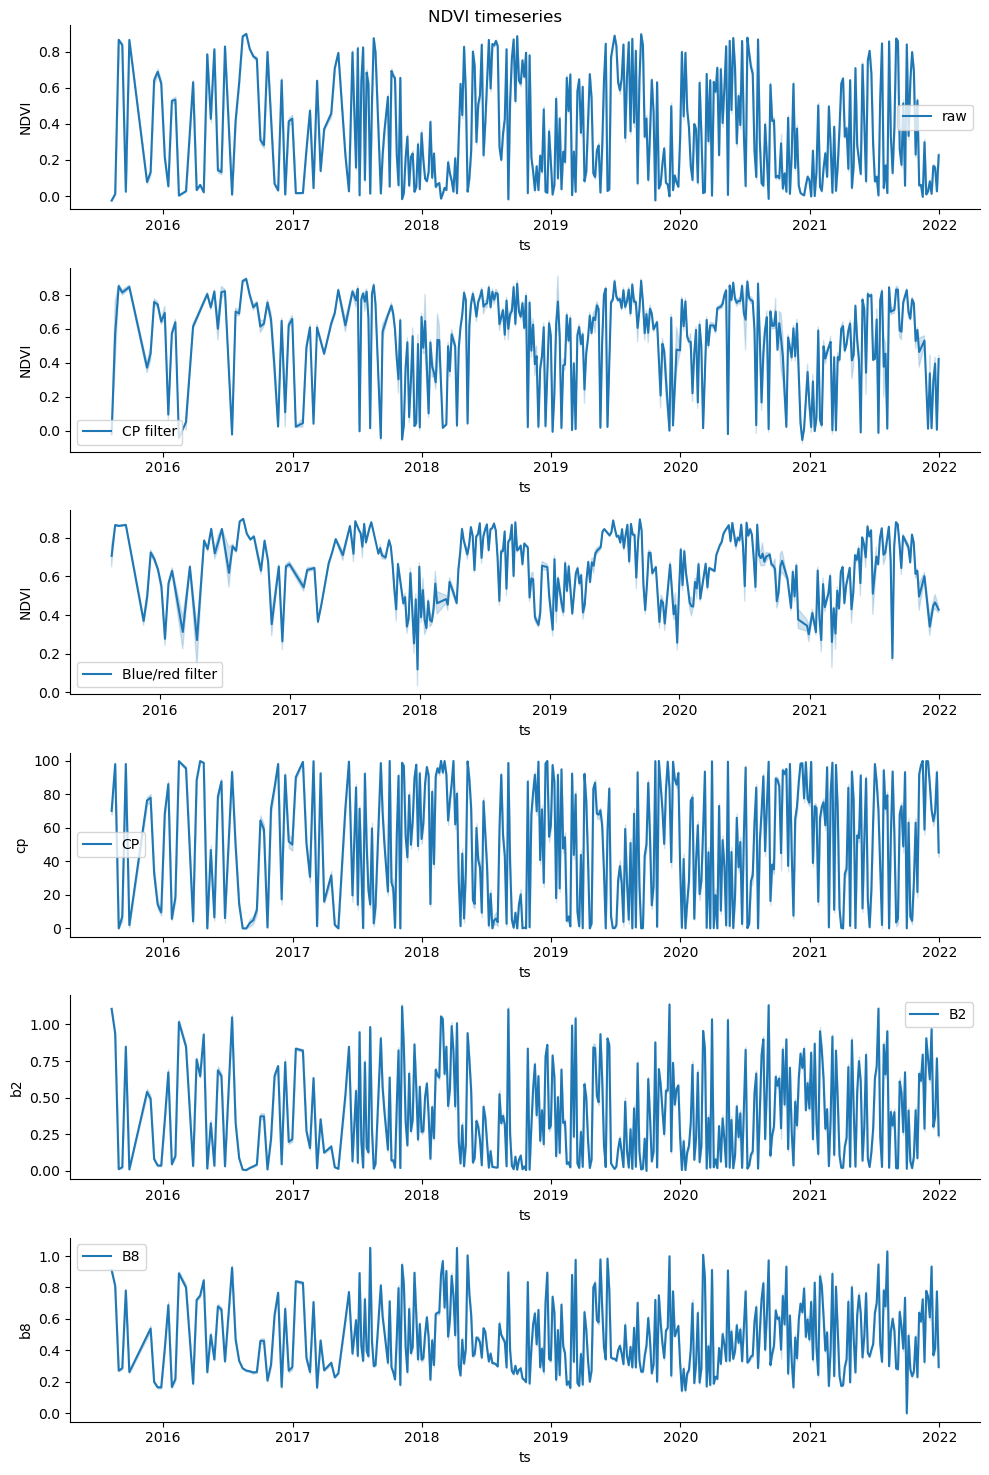

In [39]:
# Plot lineplot: filter with different methods

fig, axs = plt.subplots(6, 1, figsize=(10, 15))
plt.suptitle('NDVI timeseries')
sns.lineplot(ax=axs[0], x='ts', y='NDVI', data=df_bands_ts_NDVI, label='raw')
sns.lineplot(ax=axs[1], x='ts', y='NDVI', data=df_bands_ts_NDVI[df_bands_ts_NDVI.cp==0],label='CP filter')
sns.lineplot(ax=axs[2],  x='ts', y='NDVI', data=df_bands_ts_NDVI[(df_bands_ts_NDVI.b2<0.10) & (df_bands_ts_NDVI.b8>0.10)],label='Blue/red filter')
sns.lineplot(ax=axs[3],  x='ts', y='cp', data=df_bands_ts_NDVI, label='CP')
sns.lineplot(ax=axs[4],  x='ts', y='b2', data=df_bands_ts_NDVI, label='B2')
sns.lineplot(ax=axs[5],  x='ts', y='b8', data=df_bands_ts_NDVI, label='B8')
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
sns.despine(top=True, right=True)
plt.tight_layout()

In [25]:
df_bands_ts_NDVI = df_bands_ts_NDVI[df_bands_ts_NDVI.ts.isin(np.unique(df_bands_ts.ts))]
df_bands_ts['NDVI'] = df_bands_ts_NDVI.NDVI
df_bands_ts['CP'] = df_bands_ts_NDVI.cp

In [ ]:
# Keep only CP=0
df_bands_ts = df_bands_ts[df_bands_ts.CP==0]

In [ ]:
df_bands_ts = df_bands_ts.sort_values('ts')

"""
with open('df_bands_ts.pkl', 'wb') as f:
    pickle.dump(df_bands_ts, f)
"""
    
df_bands_no_ts = df_bands_ts.drop(columns='ts', axis=1)

In [ ]:
df_bands_ts

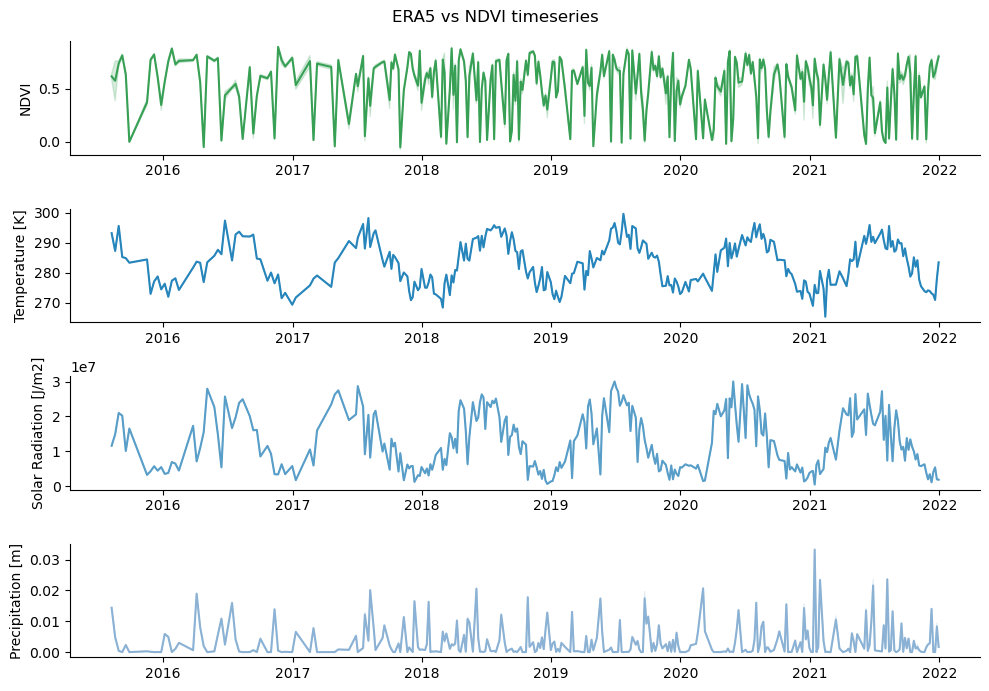

In [100]:
# Plot lineplot: ERA vs NDVI
palette1 = sns.color_palette("Greens_r", 8)
palette2 = sns.color_palette("PuBu_r", 8)
fig, axs = plt.subplots(4, 1, figsize=(10, 7))
plt.suptitle('ERA5 vs NDVI timeseries')
sns.lineplot(ax=axs[0], x='ts', y='NDVI', data=df_bands_ts, color=palette1[2])
axs[0].set(xlabel='', ylabel='NDVI')
sns.lineplot(ax=axs[1], x='ts', y='Temp', data=df_bands_ts, color=palette2[2])
axs[1].set(xlabel='', ylabel='Temperature [K]')
sns.lineplot(ax=axs[2], x='ts', y='SR', data=df_bands_ts, color=palette2[3])
axs[2].set(xlabel='', ylabel='Solar Radiation [J/m2]')
sns.lineplot(ax=axs[3], x='ts', y='Total Prec', data=df_bands_ts, color=palette2[4])
axs[3].set(xlabel='', ylabel='Precipitation [m]')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
sns.despine(top=True, right=True)
plt.tight_layout()

/tmp/ipykernel_3347489/708084086.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df_NDVI_cleaned = df_bands_ts.groupby(df_bands_ts['ts'].dt.week).apply(lambda x: x.drop(x[x.NDVI < x.NDVI.quantile(.10)].index))


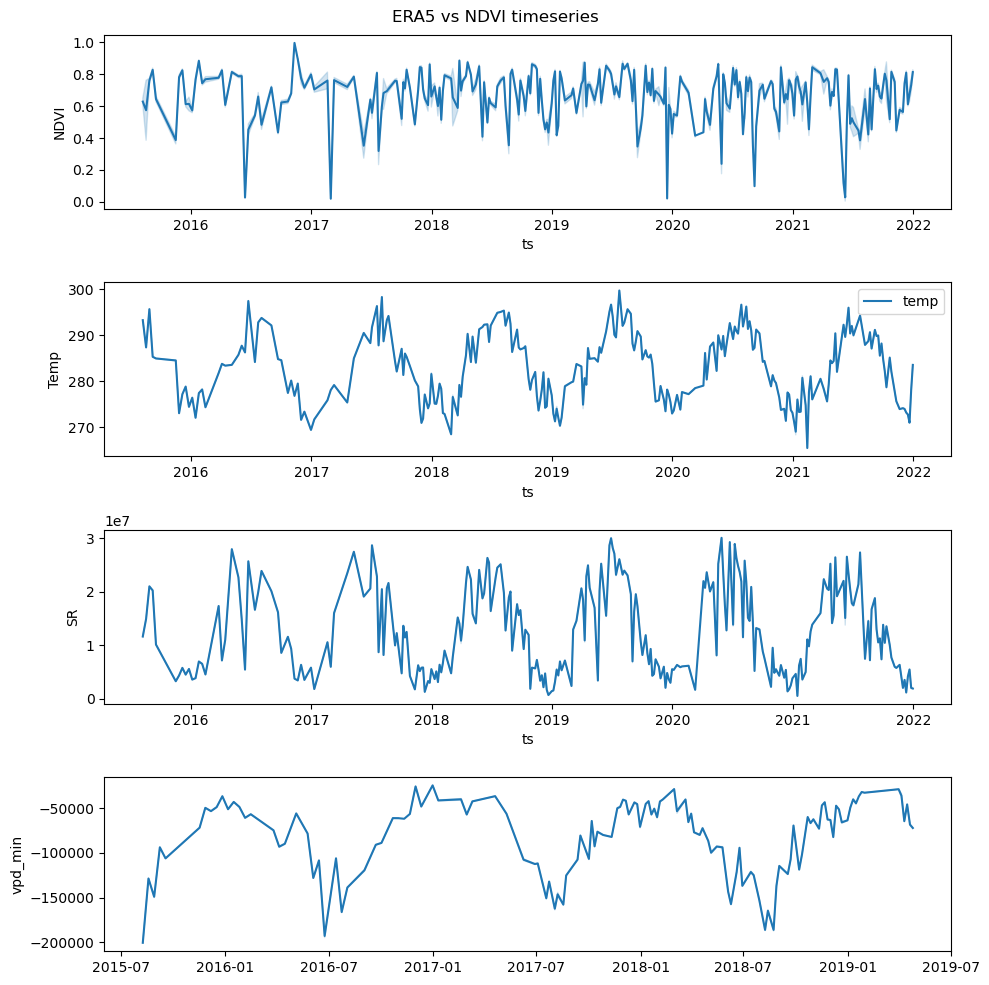

In [70]:
# Drop lower 10% of NDVI data binned by week
# Groupby week and find the lower 5th percentile
df_NDVI_cleaned = df_bands_ts.groupby(df_bands_ts['ts'].dt.week).apply(lambda x: x.drop(x[x.NDVI < x.NDVI.quantile(.10)].index))
df_NDVI_cleaned.reset_index(drop=True, inplace=True)


fig, axs = plt.subplots(4, 1, figsize=(10, 10))
plt.suptitle('ERA5 vs NDVI timeseries')
sns.lineplot(ax=axs[0], x='ts', y='NDVI', data=df_NDVI_cleaned, palette='Set2')
sns.lineplot(ax=axs[1], x='ts', y='Temp', data=df_NDVI_cleaned, palette='Set2', label='temp')
sns.lineplot(ax=axs[2], x='ts', y='SR', data=df_NDVI_cleaned, palette='Set2')
sns.lineplot(ax=axs[3], x='ts', y='vpd_min', data=df_NDVI_cleaned, palette='Set2')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')
plt.tight_layout()

<AxesSubplot:>

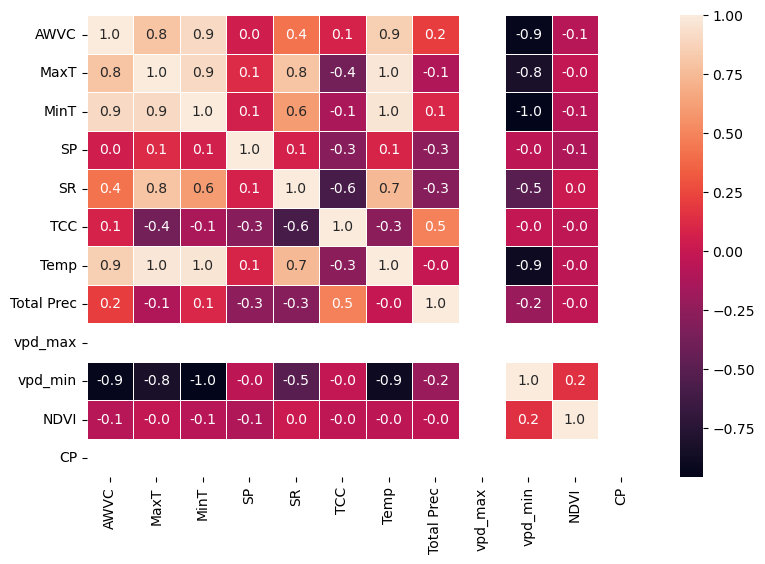

In [56]:
# Plot a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
df_new = df_bands_ts
sns.heatmap(df_new.corr(), linewidths=.5, ax=ax, annot=True, fmt=".1f") #, center=0, vmax=1, vmin=-1)

<AxesSubplot:>

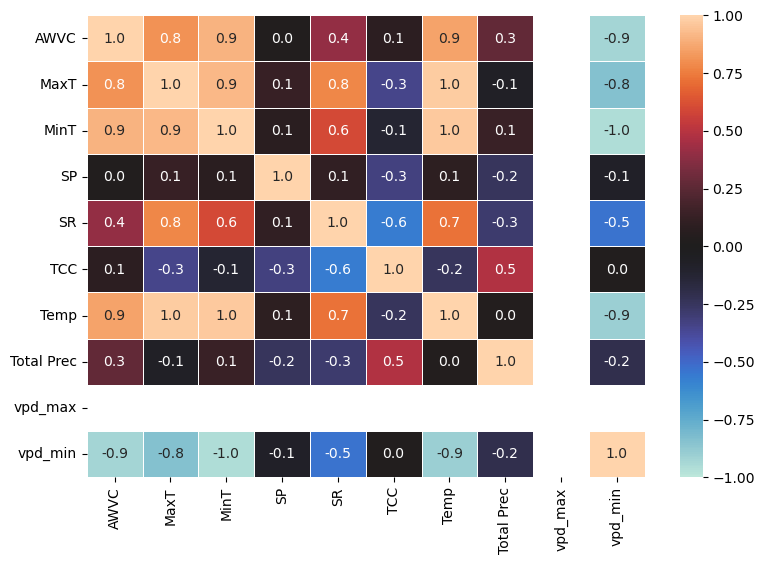

In [12]:
# Plot a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
#sns.heatmap(df, linewidths=.5, ax=ax, mask=df.isnull()) # annot=True, fmt="d", 
sns.heatmap(df_bands_ts.corr(), linewidths=.5, ax=ax, annot=True, fmt=".1f", center=0, vmax=1, vmin=-1)

In [ ]:
# Generate a mask for the upper triangle
mask_tri = np.triu(np.ones_like(df_bands_ts.corr(), dtype=bool))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df_bands_ts.corr(), mask=mask_tri,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f", center=0, vmax=1, vmin=-1)

#### Timeseries

In [ ]:
# Keep in long format
with open('df_heat.pkl', 'rb') as f:
    df = pickle.load(f)

In [ ]:
# Drop CP and SCL for now
df = df[~df['band'].isin(['CP','SCL'])]

In [ ]:
# Add timeseries
list_times = list()
for folder in os.listdir(data_path):
    if folder in complete_folders_jura: #jura region, complete data
        timestamp = datetime.strptime(folder.split('T')[0], '%Y-%m-%d')
        list_times.append(timestamp)

bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8a", "B11", "B12", "NDVI", "CP", "SCL"]# "NDWI", "NDMI", "MSI", "NDVIre"]

list_times = list(itertools.chain.from_iterable(itertools.repeat(x, 1000) for x in list_times)) # Repeat for 1000 pixels
list_times = list(itertools.chain.from_iterable(itertools.repeat(x, len(bands)-2) for x in list_times)) # Repeat for  all bands
df['ts']=list_times
df = df.sort_values('ts')
df.head()

In [ ]:
# Extract time data
df['year'] = df.ts.apply(lambda x: x.year)
df['day'] = df.ts.apply(lambda x: x.dayofyear)
df['month'] = df.ts.apply(lambda x: x.month)
df['month_name'] = df.ts.apply(lambda x: x.month_name())
df['week'] = df.ts.apply(lambda x: x.week)
df.head()

In [ ]:
# All bands timeseries
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
plt.title('Sentinel-2 timeseries')
sns.lineplot(ax=ax, x='ts', y='value', hue='band', data=df, errorbar=['ci', 0.95])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.xlabel('')

In [ ]:
sns.set_style("white")
g = sns.FacetGrid(df, row="year", hue='band', margin_titles=True, height=2, aspect=5) # could add hue = 'band' if multiple bands
g.fig.suptitle('Sentinel-2 timeseries over years')
g.map(sns.lineplot, "month", "value") # originally put months, but aggregates to montly values. Can put ci=None to view better, but remember that its an aggregate value
g.add_legend()
#g.set_xticklabels(labels=['Feb', 'Apr', 'Jun', 'Aug', 'Oct', 'Dec'])

In [ ]:
# NDVI timeseries
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('NDVI timeseries')
sns.lineplot(ax=ax, x='ts', y='value', data=df[df.band=='NDVI'])

df_NDVI = df[df.band=='NDVI']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('NDVI pre-2018')
sns.lineplot(ax=ax, x='ts', y='value', data=df_NDVI[df_NDVI.ts<'2019-01-01'])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('NDVI post-2018')
sns.lineplot(ax=ax, x='ts', y='value', data=df_NDVI[df_NDVI.ts>'2019-01-01'])

# Timeseries with error bars

In [ ]:
# NDVI timeseries with +/- 1 SD

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('NDVI timeseries')
sns.lineplot(ax=ax, x='ts', y='value', data=df[df.band=='NDVI'], errorbar=('sd'))

df_NDVI = df[df.band=='NDVI']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('NDVI pre-2018')
sns.lineplot(ax=ax, x='ts', y='value', data=df_NDVI[df_NDVI.ts<'2019-01-01'],  errorbar=('sd'))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('NDVI post-2018')
sns.lineplot(ax=ax, x='ts', y='value', data=df_NDVI[df_NDVI.ts>'2019-01-01'],  errorbar=('sd'))

# Timeseries for average of locations for every timestep

In [ ]:
df_gb = df.groupby(['ts', 'band']).mean().value.reset_index()

# NDVI timeseries

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('NDVI timeseries')
sns.lineplot(ax=ax, x='ts', y='value', data=df_gb[df_gb.band=='NDVI'])

df_NDVI = df_gb[df_gb.band=='NDVI']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('NDVI pre-2018')
sns.lineplot(ax=ax, x='ts', y='value', data=df_NDVI[df_NDVI.ts<'2019-01-01'])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.title('NDVI post-2018')
sns.lineplot(ax=ax, x='ts', y='value', data=df_NDVI[df_NDVI.ts>'2019-01-01'])

# Timeseries decomposition

In [ ]:
# Seasonal decomposition
df_NDVI = df_gb[df_gb.band=='NDVI']
result=statsmodels.tsa.seasonal.seasonal_decompose(df_NDVI['value'], model='additive', period=12)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
result.trend.plot(ax=ax)
plt.show()

In [ ]:
result.plot()

#### Map variables (folium?)

In [ ]:
m = folium.Map([37, 0], zoom_start=1) #tiles="stamentoner")
im = gdal.Open(data_path + '/' + folder + '/' + file) # to correct
merc = os.path.join("data", "Mercator_projection_SW.png")


if not os.path.isfile(merc):
    print(f"Could not find {merc}")
else:
    img = folium.raster_layers.ImageOverlay(
        name="Mercator projection SW",
        image=merc,
        bounds=[[-82, -180], [82, 180]],
        opacity=0.6,
        interactive=True,
        cross_origin=False,
        zindex=1,
    )

    folium.Popup("I am an image").add_to(img)

    img.add_to(m)
    folium.LayerControl().add_to(m)

m

In [ ]:
src = rasterio.open(data_path + '/' + folder + '/' + file)
                    arr = src.read(1)
                    # mask out nan values
                    arr[arr==-9999] = np.nan
                    masked_array = np.ma.array(arr, mask=np.isnan(arr))
                    plt.imshow(masked_array, aspect='auto', origin='lower')
                    plt.title(f'{file}')
                    plt.show()
cx.add_basemap(ax, crs=db.crs.to_string())

# Creating swath plots
- Jan-Apr 2017 timestamps
- add index for different occurences

In [ ]:
dt_list = pd.date_range("2017-01-01", periods=100, freq="D")

In [ ]:
dt_list[90]

In [ ]:
swath1 = np.zeros(100)
swath2 = np.zeros(100)
swath3 = np.zeros(100)
swath4 = np.zeros(100)
swath5 = np.zeros(100)

In [ ]:
# Swath 5: 7-3-7-3 days. Starting on day 0
swath5[3:93:10]= 1 #start:stop:step
swath5[0:100:10]= 1 
swath5[swath5==0]=np.nan

In [ ]:
# Swath 4: 10 days
swath4[0:100:10]= 2
swath4[swath4==0]=np.nan

In [ ]:
# Swath 3: 7-3-7-3 days. Starting on day 7
swath3[7:97:10]= 3 #start:stop:step
swath3[10:100:10]= 3 
swath3[swath3==0]=np.nan

In [ ]:
# Swath 2: 10 days. Starting on day 7
swath2[7:97:10]= 4
swath2[swath2==0]=np.nan

In [ ]:
# Swath 1: 7-3-7-3 days. Starting on day 4
swath1[4:94:10]= 5 #start:stop:step
swath1[7:97:10]= 5
swath1[swath1==0]=np.nan

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
from datetime import timedelta 
dt_list[0]- timedelta(1)

In [ ]:
# Plot of timestamps: different locations, all years
sns. set_palette(palette=sns.color_palette("Dark2"))

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
plt.title('Sentinel-2 data timestamps (2017)')
sns.scatterplot(ax=ax, x=dt_list, y=swath1, label='Swath 1')
sns.scatterplot(ax=ax, x=dt_list, y=swath2, label='Swath 2')
sns.scatterplot(ax=ax, x=dt_list, y=swath3, label='Swath 3')
sns.scatterplot(ax=ax, x=dt_list, y=swath4, label='Swath 4')
sns.scatterplot(ax=ax, x=dt_list, y=swath5, label='Swath 5')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

plt.xticks(rotation=45)
plt.ylabel("Presence of data")
plt.yticks([])  # Command for hiding y-axis
# Remove figure box
#fig.patch.set_visible(False)
#ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlim=(dt_list[0], dt_list[90]))
plt.grid(which='major', linestyle='--') 
plt.grid(which='minor', linestyle=':') 
plt.show()

# Number of forest pixels in different regions

In [3]:
for_path = '/dccstor/cimf/drought_impact/downloads/forest_mask/'

In [22]:
# Open binary file, count forest pixels, ratio forest
from rasterio.windows import from_bounds

for folder in os.listdir(for_path):
    if folder.startswith('4'):
        forest_binary = for_path+folder+'/forest_mask_binary.tiff'
        print('coords:', folder.split('_'))
        
        min_lat = float(folder.split('_')[0])
        min_lon = float(folder.split('_')[1])
        max_lat = float(folder.split('_')[2])
        max_lon = float(folder.split('_')[3])
        if  folder.split('_') == ['46.630', '6.379', '47.700', '6.507']: # Vaud region correct coordinates
                max_lat -= 1
            
        with rasterio.open(forest_binary, 'r') as src:
            arr = src.read(1)
            if  folder.split('_') == ['46.630', '6.379', '47.700', '6.507']: # Vaud region correct coordinates
                arr = src.read(1, window=from_bounds(min_lon, min_lat, max_lon, max_lat, src.transform))
            for_pix = arr[arr==1]
            
            print(f'Forest pixs {len(for_pix.flatten())}, Tot pixs {len(arr.flatten())}, Ratio forest {len(for_pix.flatten())/len(arr.flatten())}')

            x = (max_lat - min_lat)*111000 # 1 degree of latitude corresponds to 111km
            y = (max_lon - min_lon)*73000  # 1 degree of longitude corresponds to 73km
            
            print(f'Total patch area: {x*y:.4e} m^2\n')

coords: ['46.630', '6.379', '47.700', '6.507']
Forest pixs 65388, Tot pixs 136500, Ratio forest 0.47903296703296705
Total patch area: 7.2603e+07 m^2

coords: ['46.907', '7.137', '47.407', '7.637']
Forest pixs 1444239, Tot pixs 3841600, Ratio forest 0.3759472615576843
Total patch area: 2.0258e+09 m^2

coords: ['46.000', '7.02', '46.372', '7.435']
Forest pixs 787772, Tot pixs 2364544, Ratio forest 0.33316022032155035
Total patch area: 1.2509e+09 m^2

coords: ['47.586', '8.397', '47.807', '8.756']
Forest pixs 318319, Tot pixs 1234752, Ratio forest 0.2577999468719225
Total patch area: 6.4288e+08 m^2



# Correlation of features

In [4]:
# Sample the same 1000 forest pixels

# From SAC notebook

with open('for_pixs.pkl', 'rb') as f:
    for_pixs = pickle.load(f)

with open('row_pixs.pkl', 'rb') as f:
    row_pixs = pickle.load(f)

with open('col_pixs.pkl', 'rb') as f:
    col_pixs = pickle.load(f)
    
with open('df_samples.pkl', 'rb') as f:
    df_samples = pickle.load(f)    

In [170]:
data_path = '/dccstor/cimf/drought_impact/downloads/DEM_ch/21/46.907_7.137_47.407_7.637/'
feats = ["rugg_21", "rugg_19", "rugg_17", "slope_21", "slope_19", "slope_17", "twi_21", "twi_19", "twi_17", "curv_21", "curv_19", "curv_17",
         "northing_21", "northing_19", "northing_17", "easting_21", "easting_19", "easting_17", "DEM"]

df = pd.DataFrame()

for n, band in enumerate(feats):
    for file in os.listdir(data_path):
        if (file.endswith('.tiff') & bool(re.search(band,file))):
            with rasterio.open(data_path + file) as src:
                data = src.read(1)
            band_sample = [data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
            #band_data = np.append(band_data, band_sample)
                    
            df[band] = band_sample

    #df = pd.concat([df, df_tmp], axis=1, ignore_index=True)

In [153]:
df

rugg_21    rugg_19     rugg_17   slope_21   slope_19   slope_17  \
0     4.394458  10.910074   29.332598  12.127673   5.157251   3.680264   
1    12.162538  33.935799   99.283218  15.393308   4.802304   3.125896   
2    15.925329  42.227123   96.395248  35.124443  21.323423  14.170723   
3    12.373413  47.864826  101.697914  31.606174  25.150753  11.911505   
4     7.545385  29.909107  105.044167  21.153357  20.480618  13.255111   
..         ...        ...         ...        ...        ...        ...   
995   7.481355  23.167225   46.331882  17.770935  11.446276   6.383516   
996   1.613076   6.522229   24.603458   5.412106   5.223463   3.557513   
997   1.952093   4.772000    7.470070   4.871593   2.637935   0.664560   
998   6.284188  28.739771   54.104904  18.248262  16.674345   5.782660   
999   8.795851  43.944775  111.547859  20.176405  23.680470  14.609861   

        twi_21    twi_19     twi_17   curv_21   curv_19   curv_17  \
0     3.617086  5.700954   3.437013  0.000760 -0.000843 -0.000035   
1    13.929297  7.576652  10.266981 -0.014874 -0.003265 -0.001082   
2     1.044907  0.940699   2.069510 -0.000684  0.002243 -0.000365   
3     0.485560  1.449203   1.556168 -0.001156  0.003521 -0.000030   
4     2.741250  2.083452   1.445777 -0.002172 -0.000053  0.000243   
..         ...       ...        ...       ...       ...       ...   
995   2.524151  4.369723   2.190358 -0.001543 -0.000554  0.000283   
996   4.553833  5.336730   4.164174  0.000539 -0.000275 -0.000063   
997   4.541834  3.077524   5.555424 -0.000049  0.000117 -0.000074   
998   2.208133  1.898700   2.289960  0.001116  0.001052  0.000095   
999   2.792898  1.517399   1.344522  0.000663  0.000805 -0.000201   

     northing_21  northing_19  northing_17  easting_21  easting_19  \
0       0.640397     0.712974     0.999458   -0.768044   -0.701191   
1      -0.996767    -0.131270     0.981381    0.080349   -0.991347   
2      -0.824925    -0.651277     0.566797   -0.565243   -0.758840   
3       0.584797     0.857132     0.849963    0.811180    0.515097   
4      -0.450101    -0.589570    -0.113764    0.892978    0.807718   
..           ...          ...          ...         ...         ...   
995     0.883948     0.292758     0.163542   -0.467586   -0.956187   
996    -0.121230    -0.138588    -0.191819   -0.992624   -0.990350   
997     0.832827     0.899935    -0.328239   -0.553533   -0.436024   
998    -0.427960    -0.788489    -0.309625   -0.903798   -0.615049   
999     0.943737     0.954934     0.913055   -0.330696   -0.296818   

     easting_17          DEM  
0     -0.032906   614.432861  
1     -0.192071   503.110107  
2     -0.823857  1264.963867  
3     -0.526842   833.045959  
4      0.993508   915.498413  
..          ...          ...  
995   -0.986536   778.111267  
996   -0.981430   541.914307  
997    0.944595   620.110779  
998   -0.950859   489.324768  
999   -0.407837  1249.781860  

[1000 rows x 19 columns]

<AxesSubplot:>

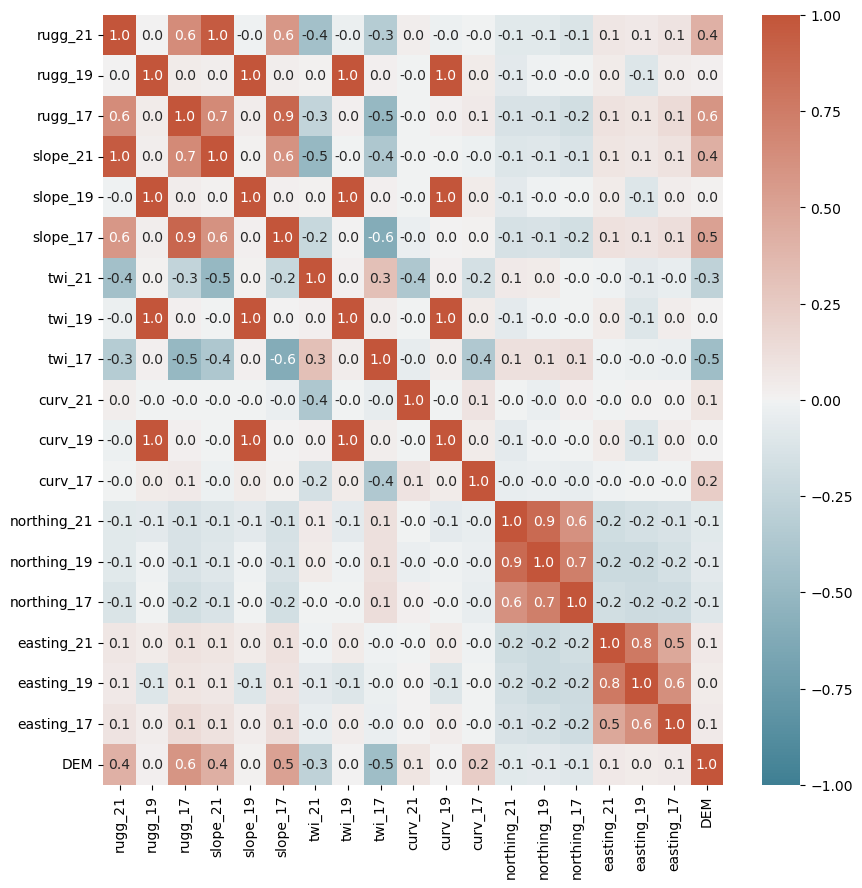

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
palette = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(df.corr(), annot=True, fmt=".1f", ax=ax, cmap=palette, center=0, vmax=1, vmin=-1)

<AxesSubplot:>

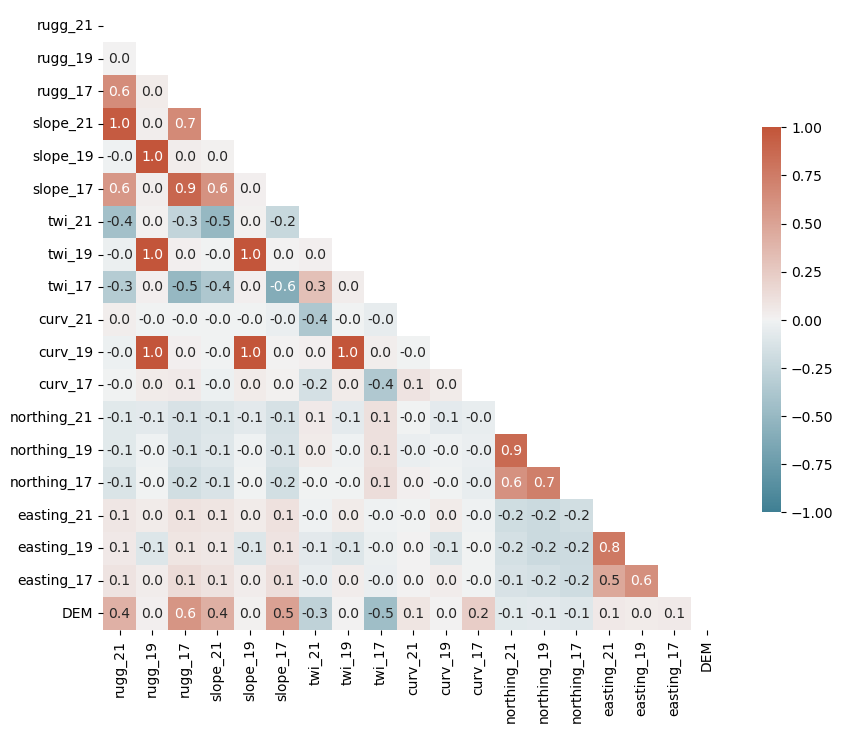

In [7]:
# Generate a mask for the upper triangle
mask_tri = np.triu(np.ones_like(df.corr(), dtype=bool))

f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), mask=mask_tri, ax=ax,
            square=True, cbar_kws={"shrink": .5}, annot=True, fmt=".1f", cmap=palette, center=0, vmax=1, vmin=-1)

### Add mean summer NDVI for cloud-free values

In [18]:
# Get NDVI and CP

# USING SAME DF AS IN BOXPLOTS
bands = ["NDVI"]#, "SCL", "CP", "NDWI", "NDMI", "MSI", "NDVIre"]
data_path = SEN_PATH
df_NDVI = pd.DataFrame()

for n, band in enumerate(bands):
    band_data = np.array([])
    cp_data = np.array([])
    b2_data = np.array([])
    b8_data = np.array([])
    to_search = '\[' +  band + '\]'
    cp_search =  '\[' + 'CP' + '\]'
    b2_search = '\[' + 'B02' + '\]'
    b8_search = '\[' + 'B08' + '\]'
    for folder in os.listdir(data_path):
        if folder in complete_folders_jura: #jura region, complete data
            for file in os.listdir(data_path + '/' + folder):
                if (file.endswith('.tiff') & bool(re.search(f'{to_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        data = src.read(1)
                    band_sample = [data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    band_data = np.append(band_data, band_sample)
                if (file.endswith('.tiff') & bool(re.search(f'{cp_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        cp = src.read(1)
                    cp_sample = [cp[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    cp_data = np.append(cp_data, cp_sample)
                    
                if (file.endswith('.tiff') & bool(re.search(f'{b2_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        blue = src.read(1)
                    blue_sample = [blue[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    b2_data = np.append(b2_data, blue_sample)
                    
                if (file.endswith('.tiff') & bool(re.search(f'{b8_search}',file))):
                    with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                        infrared = src.read(1)
                    infr_sample = [infrared[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
                    b8_data = np.append(b8_data, infr_sample)
                    
        # Replace -9999 with nan
        band_data[band_data==-9999] = np.nan
        cp_data[cp_data==-9999] = np.nan
        df_tmp = pd.DataFrame({'band': [band]*len(band_data) , 'value': band_data, 'cp':cp_data, 'b2':b2_data, 'b8':b8_data})

    df_NDVI = pd.concat([df_NDVI, df_tmp], ignore_index=True)
    
    
df_bands_ts_NDVI = pd.DataFrame()
for group_id, rows in df_NDVI.groupby('band'):
    df_bands_ts_NDVI[f"{group_id}"] = rows['value'].values.tolist() 
df_bands_ts_NDVI['cp'] = df_NDVI.cp
df_bands_ts_NDVI['b2'] = df_NDVI.b2
df_bands_ts_NDVI['b8'] = df_NDVI.b8
                    
data_path = SEN_PATH
list_times = list()
for folder in os.listdir(data_path):
    if folder in complete_folders_jura: #jura region, complete data
        timestamp = datetime.strptime(folder.split('T')[0], '%Y-%m-%d')
        list_times.append(timestamp)

list_times = list(itertools.chain.from_iterable(itertools.repeat(x, 1000) for x in list_times))
df_bands_ts_NDVI['ts']=list_times

In [5]:
"""
with open('df_NDVI_bands.pkl', 'wb') as f:
    pickle.dump(df_bands_ts_NDVI, f)
"""

with open('df_NDVI_bands.pkl', 'rb') as f:
    df_bands_ts_NDVI = pickle.load(f)

In [171]:
col_new = {'rugg_21': 'RUGG 21', 'rugg_19': 'RUGG 19', 'rugg_17': 'RUGG 17', 'slope_21': 'SLOP 21', 'slope_19':'SLOP 19', 'slope_17': 'SLOP 17',
       'twi_21': 'TWI 21', 'twi_19': 'TWI 19', 'twi_17':'TWI 17', 'curv_21':'CURV 21', 'curv_19':'CURV 19', 'curv_17':'CURV 17',
       'northing_21': 'NORT 21', 'northing_19': 'NORT 19', 'northing_17': 'NORT 17', 'easting_21':'EAST 21', 'easting_19': 'EAST 19',
       'easting_17': 'EAST 17'}

df = df.rename(columns=col_new)
df = df.reindex(sorted(df.columns), axis=1)

<AxesSubplot:>

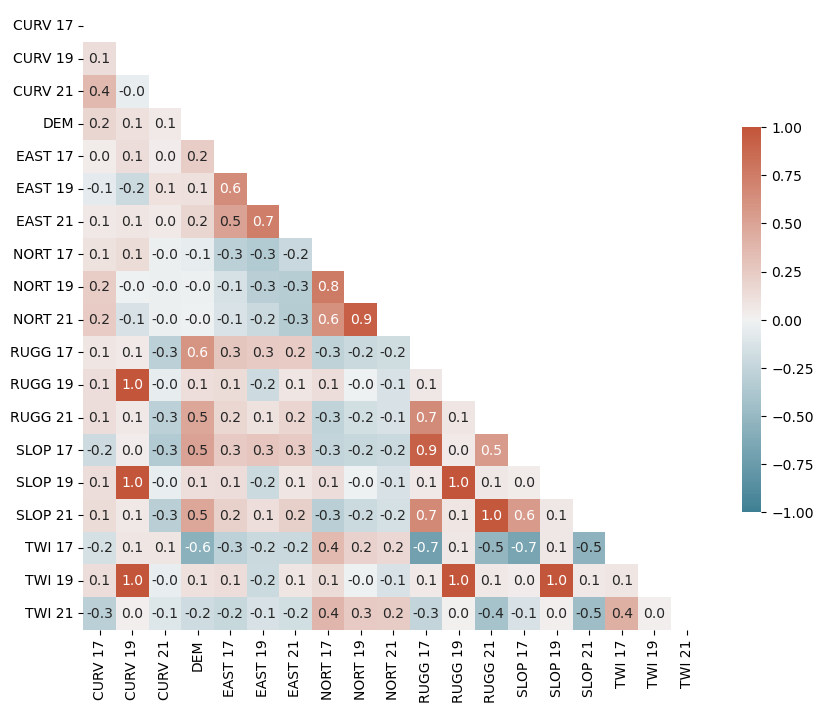

In [172]:
# Compare with mean NDVI in summers for locations where at least 100 cloud free ts

list_loc = list(itertools.chain.from_iterable(itertools.repeat(x, 386) for x in range(1000)))
df_bands_ts_NDVI['locat'] = list_loc

summer_ndvi = df_bands_ts_NDVI[df_bands_ts_NDVI.ts.dt.month.isin([6,7,8])]
summer_ndvi = summer_ndvi.dropna()

count_cloudfree_ts = summer_ndvi[summer_ndvi.cp==0].groupby('locat').count().ts.reset_index()
cloud_free_pixs = count_cloudfree_ts[count_cloudfree_ts.ts>100].locat
cloud_free_ndvi = summer_ndvi[(summer_ndvi.cp==0) & (summer_ndvi.locat.isin(cloud_free_pixs))]

# Keep only pixels that are cloud free from the Topo df
df_topo = df.iloc[cloud_free_pixs]
df_topo['NDVI'] = cloud_free_ndvi.groupby('locat').mean().NDVI

# Generate a mask for the upper triangle
mask_tri = np.triu(np.ones_like(df_topo.corr(), dtype=bool))
palette = sns.diverging_palette(220, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_topo.corr(), mask=mask_tri, ax=ax,
            square=True, cbar_kws={"shrink": .5}, annot=True, fmt=".1f", cmap=palette, center=0, vmax=1, vmin=-1)

In [130]:
sunniest_day_ndvi

NDVI     cp      b2      b8         ts  locat
338000  0.8792    0.0  0.0105  0.1260 2021-06-23      0
338001  0.8117    0.0  0.0286  0.2885 2021-06-23      1
338002  0.8677    0.0  0.0381  0.4702 2021-06-23      2
338003  0.9115    0.0  0.0138  0.2501 2021-06-23      3
338004  0.6146    0.0  0.0834  0.4907 2021-06-23      4
...        ...    ...     ...     ...        ...    ...
338995  0.9015    0.0  0.0179  0.3099 2021-06-23    995
338996  0.6120    2.0  0.0843  0.3436 2021-06-23    996
338997  0.6289    2.0  0.1025  0.3800 2021-06-23    997
338998  0.1181  100.0  0.4613  0.5592 2021-06-23    998
338999  0.3332   22.0  0.2155  0.3174 2021-06-23    999

[733 rows x 6 columns]

<AxesSubplot:>

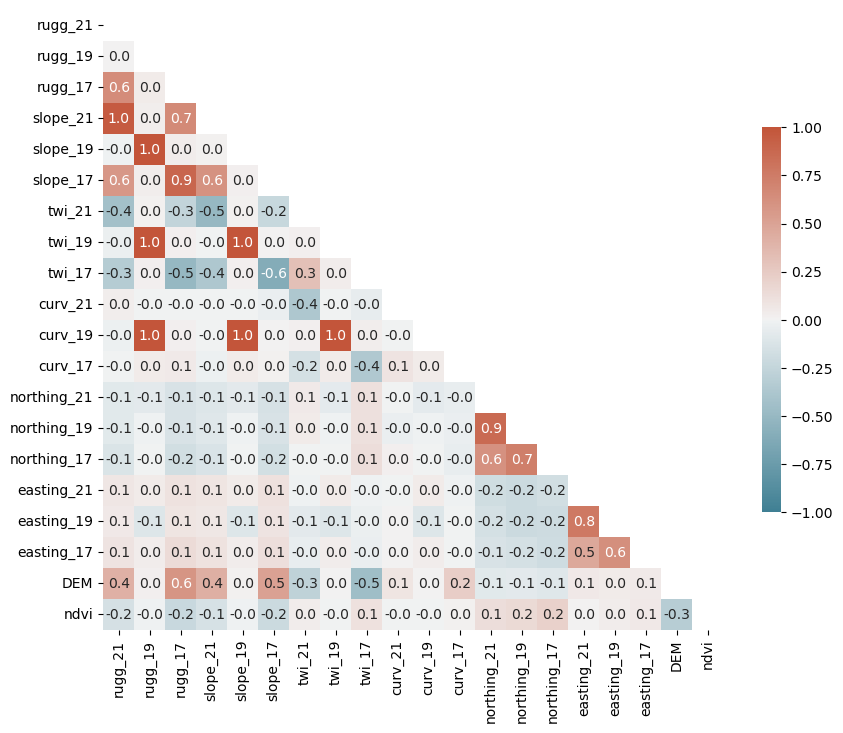

In [131]:
# Compare with NDVI in for sunniest date possible

df_bands_ts_NDVI['locat'] = [x for x in range(1000)]*386

summer_ndvi = df_bands_ts_NDVI[df_bands_ts_NDVI.ts.dt.month.isin([6,7,8])]
#summer_ndvi = summer_ndvi.dropna()

sunniest_day = summer_ndvi[summer_ndvi.cp==0].groupby('ts').count().locat.reset_index().sort_values('locat', ascending=False).head(1).ts.tolist()
sunniest_day_ndvi = summer_ndvi[(summer_ndvi.ts.isin(sunniest_day))]

# Keep only pixels that are cloud free from the Topo df
df_topo = df.copy()
df_topo['ndvi'] = sunniest_day_ndvi.NDVI.tolist()

# Generate a mask for the upper triangle
mask_tri = np.triu(np.ones_like(df_topo.corr(), dtype=bool))
palette = sns.diverging_palette(220, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_topo.corr(), mask=mask_tri, ax=ax,
            square=True, cbar_kws={"shrink": .5}, annot=True, fmt=".1f", cmap=palette, center=0, vmax=1, vmin=-1)

## Soil properties correlations

In [10]:
data_path = '/dccstor/cimf/drought_impact/downloads/ENV_DATA/46.907_7.137_47.407_7.637/'

df = pd.DataFrame()

for file in os.listdir(data_path):
    if file.endswith('.tiff'):
        result = re.search(r"\[([A-Za-z0-9_]+)\]", file)
        band = result.group(1)
        with rasterio.open(data_path + file) as src:
            data = src.read(1)
        band_sample = [data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))]
        #band_data = np.append(band_data, band_sample)

        df[band] = band_sample

In [11]:
df = df.drop('sand60_100', axis=1)

In [12]:
df[df==-9999] = np.nan

In [13]:
# Change column names
col_new = {'grav100_200': 'GRAV 100-200', 'oc5_15': 'CARB 5-15', 'dens15_30':'FED 15_30', 'forest_comp':'FC', 'grav0_5':'GRAV 0-5',
       'dens0_5':'FED 0-5', 'clay15_30':'CLAY 15-30', 'ph0_5':'PH 0-5', 'dens5_15':'FED 5-15', 'oc0_5':'CARB 0-5', 'grav15_30':'GRAV 15-30',
       'grav5_15':'GRAV 5-15', 'sand15_30':'SAND 15-30', 'sand100_200':'SAND 100-200', 'ph5_15':'PH 5-15', 'oc30_60':'CARB 30-60', 'ph60_100':'PH 60-100',
       'dens30_60': 'FED 30-60', 'ph100_200':'PH 100-200', 'sand5_15': 'SAND 5-15', 'oc60_100': 'CARB 60-100', 'sand30_60': 'SAND 30-60',
       'grav30_60': 'GRAV 30-60', 'clay0_5': 'CLAY 0-5', 'oc15_30': 'CARB 15-30', 'clay5_15': 'CLAY 5-15', 'ph15_30': 'PH 15-30', 'dens60_100': 'DENS 60-100',
       'clay60_100': 'CLAY 60-1000', 'ph30_60':'PH 30-60', 'forest_height': 'FH', 'clay100_200':'CLAY 100-200', 'soil_depth': 'SDEP',
       'oc100_200': 'CARB 100-200', 'sand0_5': 'SAND 0-5', 'clay30_60': 'CLAY 30-60', 'grav60_100': 'GRAV 60-100', 'dens100_200': 'DENS 100-200',
       'ndvi': 'NDVI'}

df = df.rename(columns=col_new)
df = df.reindex(sorted(df.columns), axis=1)

In [14]:
# Compare with NDVI in for sunniest date possible

df_bands_ts_NDVI['locat'] = [x for x in range(1000)]*386

summer_ndvi = df_bands_ts_NDVI[df_bands_ts_NDVI.ts.dt.month.isin([6,7,8])]
#summer_ndvi = summer_ndvi.dropna()

sunniest_day = summer_ndvi[summer_ndvi.cp==0].groupby('ts').count().locat.reset_index().sort_values('locat', ascending=False).head(1).ts.tolist()
sunniest_day_ndvi = summer_ndvi[(summer_ndvi.ts.isin(sunniest_day))]

# Keep only pixels that are cloud free from the soil df
df['NDVI'] = sunniest_day_ndvi.NDVI.tolist()

<AxesSubplot:>

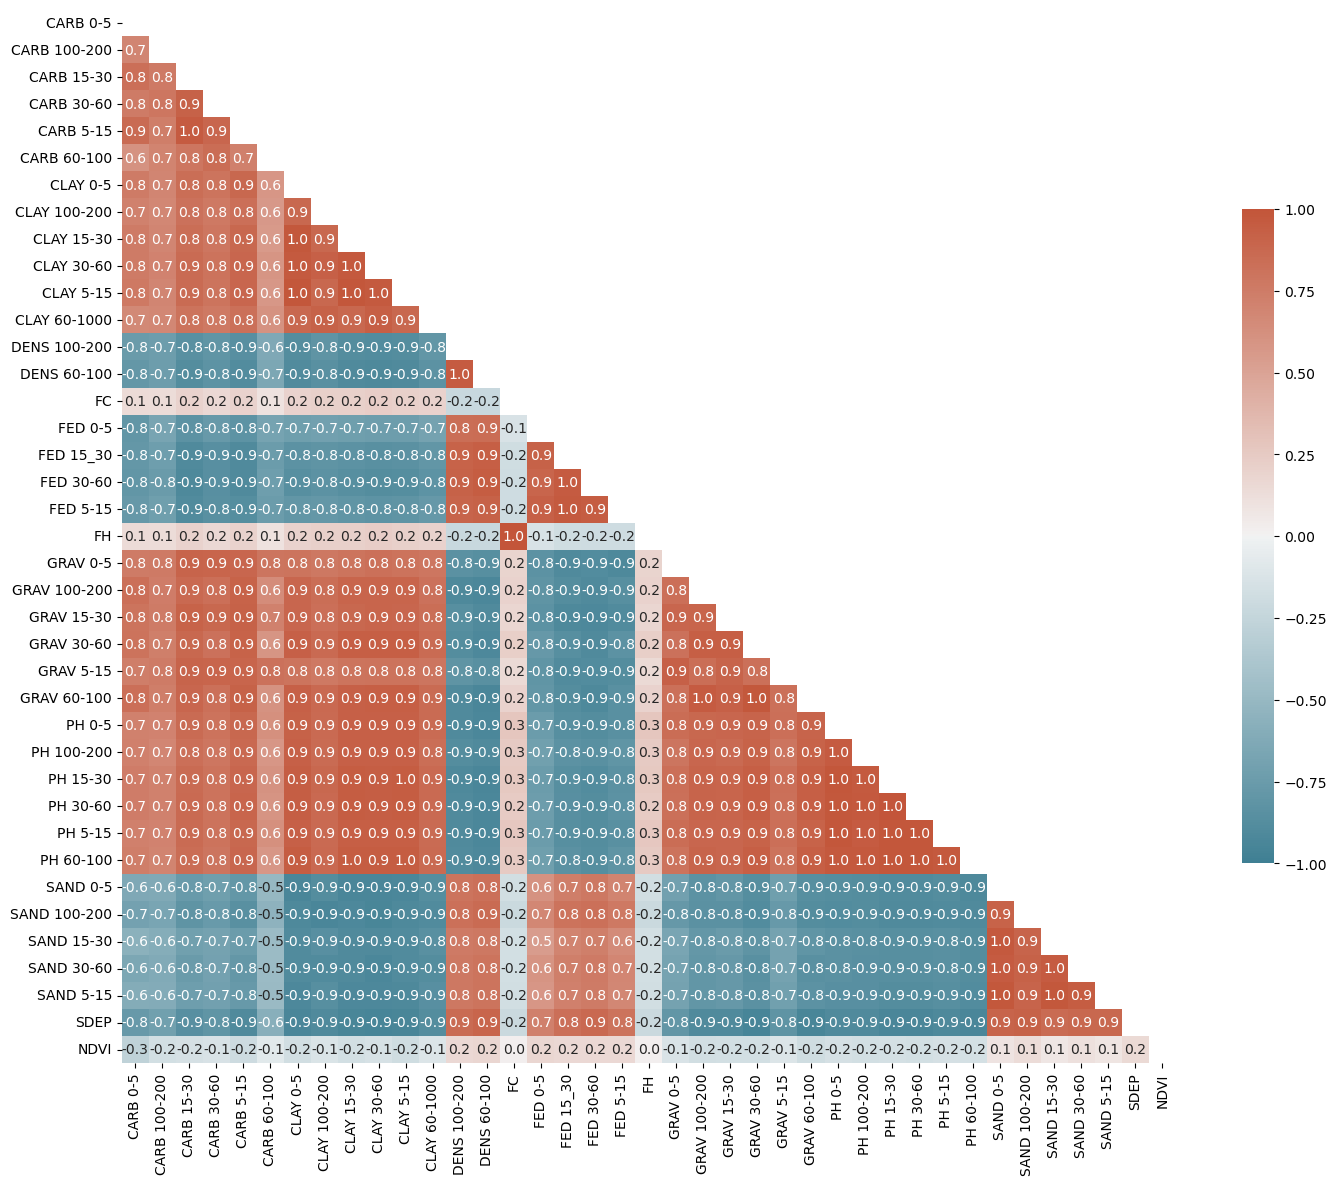

In [15]:
# Generate a mask for the upper triangle
mask_tri = np.triu(np.ones_like(df.corr(), dtype=bool))
palette = sns.diverging_palette(220, 20, as_cmap=True)

f, ax = plt.subplots(figsize=(17, 17))
sns.heatmap(df.corr(), mask=mask_tri, ax=ax,
            square=True, cbar_kws={"shrink": .5}, annot=True, fmt=".1f", cmap=palette, center=0, vmax=1, vmin=-1)

# NDVI vs CP for Jura 1000 pixels

In [18]:
def get_ndvi_at_cp(coords, for_pixs, cp_thresh):
    """
    Get NDVI pixels from given coords 
    Check median NDVI for CP = cp_thresh 
    """
    
    data_path = '/dccstor/cimf/drought_impact/downloads/SENTINEL 2'
    df_NDVI = pd.DataFrame()

    for folder in os.listdir(data_path):
        if coords in folder:
            timestamp = datetime.strptime(folder.split('Z')[0], '%Y-%m-%dT%H:%M:%S')
            if timestamp.month>=6 and timestamp.month<=9:
                for file in os.listdir(data_path + '/' + folder):

                    ndvi_search = '\[' +  'NDVI' + '\]'
                    cp_search = '\[' +  'CP' + '\]'

                    if (file.endswith('.tiff') & bool(re.search(f'{ndvi_search}',file))):
                        with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                            data = src.read(1)
                        ndvi = np.array([data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))])

                    if (file.endswith('.tiff') & bool(re.search(f'{cp_search}',file))):
                        with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                            data = src.read(1)
                        cp = np.array([data[row_pixs[i],col_pixs[i]] for i in range(len(for_pixs))])

                # Mask out forest, clouds and -9999 (as nan)
                cp[cp == -9999] = np.nan
                ndvi[ndvi == -9999] = np.nan
                ndvi[cp!=cp_thresh] = np.nan
                df_file = pd.DataFrame({'timestamp': [timestamp]*len(ndvi), 'ndvi': ndvi, 'cp':cp}) 
                df_file = df_file.dropna(axis=0)

                df_NDVI = pd.concat([df_NDVI, df_file], axis=0, ignore_index=True) 

    return df_NDVI

In [19]:
med_ndvi = np.empty((len(cp_thresholds)))
coords = '46.907_7.137_47.407_7.637'  

df_NDVI = get_ndvi_at_cp(coords, for_pixs, 60)

NameError: name 'cp_thresholds' is not defined

In [54]:
df_NDVI.ndvi.median()

0.03125

In [22]:
cp_thresholds = [100,95,90,85,80,75,70,65,60,55,50,45,40,35,30,25,20,15,10,5,0]
med_ndvi = np.empty((len(cp_thresholds)))
coords = '46.907_7.137_47.407_7.637'  

for i, cp in enumerate(cp_thresholds):
    df_NDVI = get_ndvi_at_cp(coords, for_pixs, cp)
    med_ndvi[i] = df_NDVI.ndvi.median()

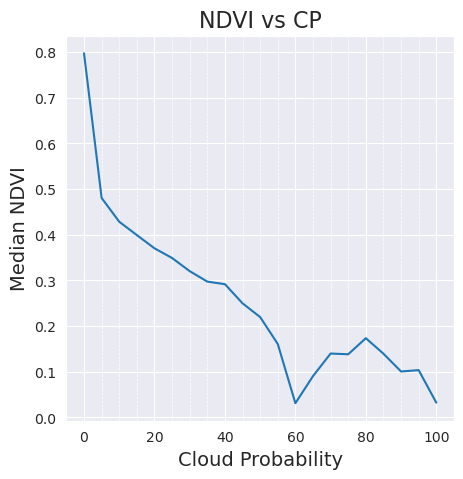

In [66]:
import matplotlib 
# Plot the change in data
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.lineplot(ax=ax, x=cp_thresholds, y=med_ndvi)
ax.set_xlabel('Cloud Probability', fontsize=14)
ax.set_ylabel('Median NDVI', fontsize=14)
ax.set_title('NDVI vs CP', fontsize=16)
sns.set_context(rc={"grid.linewidth": 0.8, "axes.edgecolor": "0.8"})
ax.grid(which='minor', linestyle='--', linewidth=0.5, color='white')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
sns.set_style("darkgrid")
plt.show()


In [24]:
cp_thresholds = [100,95,90,85,80,75,70,65,60,55,50,45,40,35,30,25,20,15,10,5,0]
med_ndvi = np.empty((len(cp_thresholds)))
coords = '46.907_7.137_47.407_7.637' 
df_NDVI_all = pd.DataFrame()

for i, cp in enumerate(cp_thresholds):
    df_NDVI = get_ndvi_at_cp(coords, for_pixs, cp)
    df_NDVI_all = pd.concat([df_NDVI_all, df_NDVI])
    med_ndvi[i] = df_NDVI.ndvi.median()

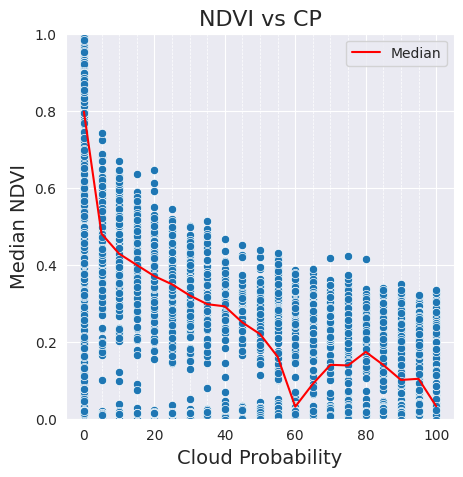

In [30]:
import matplotlib 
# Plot the change in data
fig, ax = plt.subplots(1,1, figsize=(5,5))
sns.lineplot(ax=ax, x=cp_thresholds, y=med_ndvi, color='red', label='Median')
sns.scatterplot(ax=ax, x='cp', y='ndvi', data=df_NDVI_all)
ax.set_xlabel('Cloud Probability', fontsize=14)
ax.set_ylabel('Median NDVI', fontsize=14)
ax.set_title('NDVI vs CP', fontsize=16)
sns.set_context(rc={"grid.linewidth": 0.8, "axes.edgecolor": "0.8"})
ax.grid(which='minor', linestyle='--', linewidth=0.5, color='white')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
sns.set_style("darkgrid")
plt.legend()
plt.ylim(0,1)
plt.show()
sns.set_style("darkgrid")

In [ ]:
## In Valais

In [31]:
from rasterio.windows import from_bounds

def get_ndvi_at_cp_summer(coords, cp_thresh, forest_binary, bbox):
    """
    Get NDVI pixels in bounding box if cloud proba < cp_thresh, sampling only forest pixels using the firet mask
    :param coords: coords of Valais patch to filter folders
    :param cp_thresh: cloud proba threshold. Keep if cp==cp_thresh
    :param gdf: GeoDataFrae containing cooridnates of all forest pixels in bbox
    :param forest_binary: forest mask
    :param bbox: boudning box to read data from
    """
    
    data_path = '/dccstor/cimf/drought_impact/downloads/SENTINEL 2'
    df_NDVI = pd.DataFrame()

    for folder in os.listdir(data_path):
        if coords in folder:
            timestamp = datetime.strptime(folder.split('Z')[0], '%Y-%m-%dT%H:%M:%S')
            if timestamp.month>=6 and timestamp.month<=9:
                for file in os.listdir(data_path + '/' + folder):

                    ndvi_search = '\[' +  'NDVI' + '\]'
                    CP_search = '\[' +  'CP' + '\]'

                    if (file.endswith('.tiff') & bool(re.search(f'{ndvi_search}',file))): 
                        with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                            ndvi = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))

                    if (file.endswith('.tiff') & bool(re.search(f'{CP_search}',file))): 
                        with rasterio.open(data_path + '/' + folder + '/' + file) as src:
                            cloud = src.read(1, window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))

                # Mask out forest, clouds and -9999 (as nan)
                cloud[cloud == -9999] = np.nan
                ndvi[ndvi == -9999] = np.nan
                ndvi[cloud!=cp_thresh] = np.nan
                df_file = pd.DataFrame({'timestamp': [timestamp]*len(ndvi[forest_binary].flatten()), 'ndvi': ndvi[forest_binary].flatten(), 'cp':cloud[forest_binary].flatten()}) #, 'coords':gdf['geometry']})
                df_file = df_file.dropna(axis=0)

                df_NDVI = pd.concat([df_NDVI, df_file], axis=0, ignore_index=True) 

    return df_NDVI

In [32]:
bbox_valais2 = [7.244, 46.212, 7.3683,46.2778]

# CREATE FOREST MASK AND GET COORDINATES OF FOREST PIXELS

bbox = bbox_valais2
coords = '46.000_7.02_46.372_7.435' # '46.907_7.137_47.407_7.637' 

forest_threshold = 0.95 #ratio of forest per pixel

# Create forest mask --> Use the one in valais!
forest_mask = f'/dccstor/cimf/drought_impact/downloads/forest_mask/{coords}/Drought-Continuous forest mask-11_03_2022T00_00_00.tiff'

if bbox is not None:
    with rasterio.open(forest_mask) as src:
        im_forest = rasterio.open(forest_mask)
    for_arr = im_forest.read(1,  window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
else:
    with rasterio.open(forest_mask) as src:
        im_forest = rasterio.open(forest_mask)
    for_arr = im_forest.read(1)

for_arr[for_arr==-9999] = np.nan

# Make binary mask keeping only pixels that are >50% forest
forest_binary = for_arr.copy()
forest_binary[np.isnan(forest_binary)]=0
forest_binary[forest_binary<forest_threshold]=0
forest_binary[forest_binary!=0]=1
forest_binary = (forest_binary==1)

# Get coordinates of forest pixel in bbox
with rasterio.open(forest_mask) as src:
    im_forest = rasterio.open(forest_mask)
    for_arr = im_forest.read(1,  window=from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform))
    print('shape of bbox:', for_arr.shape)
    height = for_arr.shape[0]
    width = for_arr.shape[1]
    bbox_transform = rasterio.transform.from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], width, height)
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rasterio.transform.xy(bbox_transform, rows, cols)
    lons = np.concatenate(xs).ravel()
    lats = np.concatenate(ys).ravel()

# Select forest pixels
forest_indices = np.where(forest_binary.flatten() == True)
row_pixs = forest_indices[0]
col_pixs = forest_indices[0]
lons = lons[col_pixs]
lats = lats[row_pixs]

df_coords = pd.DataFrame({'lons':lons, 'lats': lats})

# Create point geometries
gdf = gpd.GeoDataFrame(df_coords, geometry=gpd.points_from_xy(df_coords['lons'], df_coords['lats']), crs="EPSG:4326")

shape of bbox: (257, 486)


In [33]:
cp_thresholds = [100,95,90,85,80,75,70,65,60,55,50,45,40,35,30,25,20,15,10,5,0]
#mean_ndvi = np.empty((len(cp_thresholds)))
med_ndvi = np.empty((len(cp_thresholds)))
coords = '46.000_7.02_46.372_7.435' #'46.907_7.137_47.407_7.637' 
df_NDVI_all = pd.DataFrame()

for i, cp in enumerate(cp_thresholds):
    df_NDVI = get_ndvi_at_cp_summer(coords, cp, forest_binary, bbox_valais2)
    #mean_ndvi[i] = df_NDVI.ndvi.mean()
    df_NDVI_all = pd.concat([df_NDVI_all, df_NDVI])
    med_ndvi[i] = df_NDVI.ndvi.median()

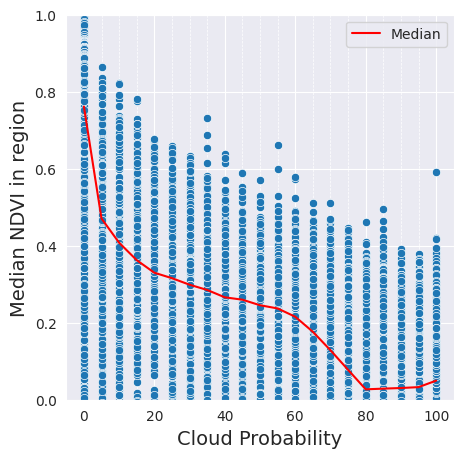

In [35]:
# Plot the change in data
fig, ax = plt.subplots(1,1, figsize=(5,5))
#sns.lineplot(ax=ax, x=cp_thresholds, y=mean_ndvi, label='mean')
#sns.lineplot(ax=ax, x=cp_thresholds, y=med_ndvi) #, label='median') #, color='red')
sns.lineplot(ax=ax, x=cp_thresholds, y=med_ndvi, color='red', label='Median')
sns.scatterplot(ax=ax, x='cp', y='ndvi', data=df_NDVI_all)
ax.set_xlabel('Cloud Probability', fontsize=14)
ax.set_ylabel('Median NDVI in region', fontsize=14)
#ax.set_title('NDVI vs CP', fontsize=16)
sns.set_context(rc={"grid.linewidth": 0.8, "axes.edgecolor": "0.8"})
#plt.gca().invert_xaxis()
ax.grid(which='minor', linestyle='--', linewidth=0.5, color='white')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
#plt.grid(True, which='major')
sns.set_style("darkgrid")
plt.ylim(0,1)
plt.show()